Group 3

* Christoffer Kleven Berg
* Marius Johan Franco Dioli
* Martin Strøm Olsen

Statistics and graphs presented will be calculated based on the training data (representing 70% of the full dataset) unless otherwise stated.

## Imports

In [1]:
%matplotlib inline
from IPython.display import Image
from IPython.core.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np

## Part 1: Historical data

### Structures in the data

In [2]:
x = pd.read_csv("./data/medical/historical_X.dat",
                        sep=" ", header=None)
personal_columns = ["sex", "smoker"]
gene_columns = ["gene " + str(i) for i in range(1, 127)]
symptom_columns = ["symptom 1", "symptom 2"]
x_columns = personal_columns + gene_columns + symptom_columns
x.columns = x_columns

y = pd.read_csv("./data/medical/historical_Y.dat",
                        sep=" ", header=None)
y.columns = ["outcome"]

a = pd.read_csv("./data/medical/historical_A.dat",
                        sep=" ", header=None)
a.columns = ["action"]
x_train, x_test, y_train, y_test, a_train, a_test = train_test_split(
            x, y, a, test_size=0.3, random_state=1)

In [3]:
x.head()

,sex,smoker,gene 1,gene 2,gene 3,gene 4,gene 5,gene 6,gene 7,gene 8,...,gene 119,gene 120,gene 121,gene 122,gene 123,gene 124,gene 125,gene 126,symptom 1,symptom 2
0,0,0,0,0,1,1,0,0,1,1,...,0,1,1,0,1,1,0,0,1,0
1,0,1,0,1,0,1,0,0,1,0,...,0,1,0,1,0,1,0,1,0,0
2,0,0,1,1,0,0,1,1,0,0,...,0,0,0,1,0,0,1,1,0,0
3,1,1,1,0,0,0,1,1,0,0,...,1,0,1,1,0,0,1,1,0,0
4,0,1,0,1,0,1,1,1,1,1,...,0,0,0,1,0,1,0,1,1,0


In [4]:
xs_train = x.iloc[:, :-2]
s1_train = x.iloc[:, -2]
s2_train = x.iloc[:, -1]

In [5]:
print(f"{y.head()} \n {a.head()}")

   outcome
0        1
1        0
2        0
3        0
4        0 
    action
0       1
1       0
2       0
3       0
4       0


#### Overview of the data

We could look at the simple distribution of the two symptoms. This shows the frequency of the two symptoms in the entire dataset. From the histogram it could seem like symptom 2 is less frequent than symptom 1.

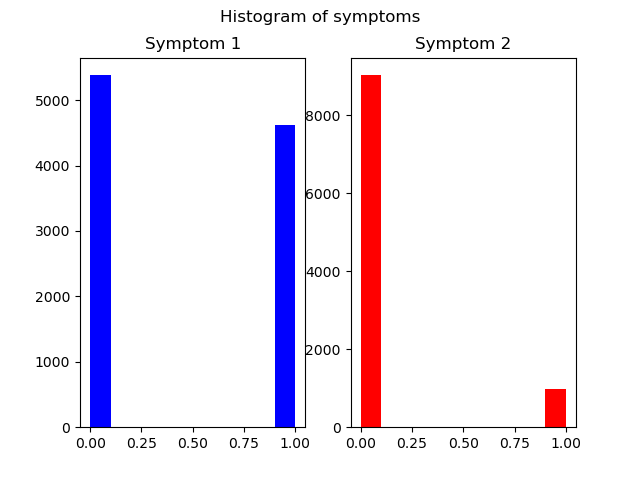

In [6]:
display(Image(filename="img/freq_hist.png", width = 600))

In [7]:
x.mean().sort_values()

symptom 2    0.0973
smoker       0.2722
symptom 1    0.4619
gene 20      0.4852
gene 102     0.4884
              ...  
gene 79      0.5098
gene 87      0.5108
gene 73      0.5108
gene 47      0.5127
gene 126     0.5781
Length: 130, dtype: float64

Further, looking at the the presence of covariates we see that ca. 27% are smokers, and that almost all the genes are represented in about half the population. We do not know if our data is a representative sample from the population in the country where this data was generated. Therefore, the genetic data in particular might not be representative, as certain genes can cluster geographically and socioeceonomically. Depending on when the the data was gathered there might also be an overrepresentation of smokers, as the smoking population has declined to 14% in recent times in the US. https://www.cdc.gov/tobacco/data_statistics/fact_sheets/adult_data/cig_smoking/index.htm

#### Single cause versus multiple cause model

We do not know how many diseases are present, and if they are caused by a single covariate or multiple covariates. To investigate this we will fit single covariate and multiple covariate models, and make use of clustering. A major weakness of single cause models is that they do not take into account higher order interactions between the covariates, which a multiple cause model can capture. However, if there is a lot of noise in the data then a single cause model can be expected to perform well. Multiple cause models also have a greater chance of overfitting the data as they have less bias than single cause models.

Just by looking at the simple histogram of frequencies we see that the distribution of the two symptoms are very different. Symptom 2 seems to be far less frequent than symptom 1. In order to look further into into unknown clusters in the data, we could use unsupervised learning techniques such as K-means clustering or hierarchical clustering. Our overall goal is to predict the symptoms based on the covariates which are gender, smoker and gene expression data. Because of the number of covariates (the number of different gene expressions), it is not trivial to examine if there is a single cause (covariate) for the symptoms or not.

There could also be a subset of gene expression that are the main cause of the symptoms, but determining which of the gene expression that explains the most of the variability in the symptoms could be more difficult to infer. This is closely related to the concept of confounding covariates. Two covariates, if correlated, could be subject to confounding in such a way that the effect of the second covariate could be partly expressed through the first covariate. In the case of two covariates, the second is then affecting through $\hat{\rho} \sqrt{\frac{\sigma_{1}}{\sigma_{2}}}$ where $\hat{\rho}$ is the correlation between the covariates, $\sigma_i$ is the standard deviation of the covariate $i$ (Borgan, 2019, p. 1). In our case this could be the case if we include some number of genes as covariates. Some genes could be confounded by other genes, masking their influence on the response variable.

By attempting to narrow down the covariates that cause a particular symptom, we are looking at a "causes of effect" problem (Dawid, 2015, p. 5). That is, what covariates causes the symptoms observed in the data set. When it comes to data sets that we observe after the "experiment" has taken place (that is, collecting the data) there should ideally be exchangeability among the observations (Dawid, 2015, p. 21). This condition may be difficult to verify when looking at the dataset, especially when taking into account the uncertainty that (may) be involved when registering data for the symptoms. These could range from objective measurese such as a level of concentration or to more subjective measures such as an individual assessment of symptoms.

Further, Dawid also discusses the negative impact of confounding when observing the data. In order to achieve this, there must in principal be exchangeability between groups within the data. He then considers the case of having the treated groups being exchangeable with the non-treated group in order to have exchangeability and that this in theory happens when the observations are randomised (Dawid, 2015, pp. 21-22). Dawid then relates the absence of confounding to independence between the covariates (Dawid, 2015, p. 22). This can also be considered when looking at the definition from Borgan above, where confounding is expressed through correlation $\hat{\rho}$ between the covariates.

##### K-means and K-modes clustering

The idea behind K-means and K-modes clustering is to find the clusters that minimize the variation within each of the K clusters. For K-means, this variation can be measured using a distance metric such as the squared euclidean distance between the covariates (denoted by $C$) of the two observations

$$
\sum_{j=1}^{C} (x_{ij} - x_{i'j})^{2}
$$

adapted from (James et al., 2013, p. 387). Euclidean distance translates poorly to our use case in which all our covariates are binary categorical variables. In this case, K-modes clustering (Huang, Z. 1998) seems the more promising method. The distance metric used in this case is defined as 

$$
d(X, Y) = \sum_{i=1}^{n}\delta(x_i, y_i)
$$ 

where $\delta(x_i, y_i) = 0$ if $(x_i=y_i)$ and $\delta(x_i, y_i) = 1$ if $(x_i\neq y_i)$. Using this, the we desire to minimes the function 

$$
P(W, Q) = \sum_{l=1}^{k}\sum_{i=1}^{n}\sum_{j=1}^{m}\omega_{i,l}\delta(x_{i,j},q_{l,j})
$$ 

So as to find the "optimal" clusters, where W is a partition of the dataset and $Q$ is the set of cluster vectors. This function is minimised by allocating observations to the cluster whose mode is nearest to it in terms of our distance metric. We update the mode after each allocation. After all the observations have been allocated we recheck the distance between all the observations and the clusters. We repeat this process until no observation changes cluster.

In this example, we could use this algorithm with $K=2$ and check the clusters created by the algorithm with the different symptoms. Intuitively, if a large percentage of the cluster 1 observations exhibit one of the symptoms compared to those observations in cluster 2 it could be reason to investigate closer if there in fact are two different clusters of observations, each mainly related to each of the symptoms. 


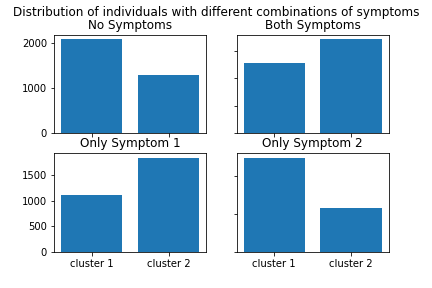

In [8]:
display(Image(filename="./img/clustering.png", width = 600))

We see interesting results from our clustering. We look at the distribtuion of four cases between the clusters, that of the asymptomatic, those with only symptom 1, those with  only symptom 2,those with  both symptoms. We observe that there is representation in both clusters of all four cases. However, symptom 1 skews towards cluster 2 while symptom 2 skews towards cluster 1 at about a 2:1 ratio. The skewness in the symptoms suggest that there are diseases in the population which tend to cause one symptom and not the other. The fact that there is substantial representation in both clusters in all the four cases suggests that there are also diseases present in our population which cause neither symptom and both symptoms respectively. However, the skewedness in the asymptomatic and both symptom cases might be a result of the fact that there is an overrepresentation of symptom 2 in the former and symptom 1 in the latter rather than the presence of additional disease classes.

##### Logistic regression

Let us now look at logistic regression as a model for the data. We shall first fit a full model on the data and then check which of the regression parameters are significant at the 0.05 level. We regress all the non-symptom covariates on symptom 1 and symptom 2 respectively.

In [9]:
log_reg_s1 = sm.Logit(s1_train, xs_train).fit()
log_reg_s2 = sm.Logit(s2_train, xs_train).fit()

s_1_significant_params_05 = []
s_2_significant_params_05 = []
for index, item in enumerate(log_reg_s1.pvalues):
    if item<0.05:
        s_1_significant_params_05.append(log_reg_s1.pvalues.index[index])
for index, item in enumerate(log_reg_s2.pvalues):
    if item<0.05:
        s_2_significant_params_05.append(log_reg_s2.pvalues.index[index]) 

Optimization terminated successfully.
         Current function value: 0.399682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.258782
         Iterations 8


In [10]:
print("Significant parameters for a regression on Symptom 1: \n",
    s_1_significant_params_05)
print("Significant parameters for a regression on Symptom 2: \n",
    s_2_significant_params_05)
intersection_05 = set.intersection(
    set(s_1_significant_params_05),
    set(s_2_significant_params_05))
print("Significant parameters for both models: \n", intersection_05)

Significant parameters for a regression on Symptom 1: 
 ['gene 2', 'gene 3', 'gene 4', 'gene 25', 'gene 34', 'gene 51', 'gene 53', 'gene 60', 'gene 69', 'gene 74', 'gene 78', 'gene 82', 'gene 89', 'gene 99', 'gene 100', 'gene 119', 'gene 120', 'gene 125']
Significant parameters for a regression on Symptom 2: 
 ['smoker', 'gene 2', 'gene 3', 'gene 5', 'gene 8', 'gene 13', 'gene 42', 'gene 44', 'gene 45', 'gene 47', 'gene 56', 'gene 57', 'gene 60', 'gene 76', 'gene 80', 'gene 97', 'gene 99', 'gene 104']
Significant parameters for both models: 
 {'gene 60', 'gene 99', 'gene 3', 'gene 2'}


We see in both models that there are multiple significant factors at the 0.05 level.  Additionally, there is an overlap between the models of genes that are significant for both symptoms. This suggests a single cause model. Our results suggest that genes 2, 3, 60, and 99 are important for disease epidemiology, as they are significant in both models. Further study of these genes is warranted based on the results of this model. However, considering the issues with p-values outlined in Dimitrakakis p. 53, which includes the fact that they only measure the fit on the data, we will corroborate these findings with other methods.

Ideally we would like to fit a model on every subset of covariates and directly compare them so as to determine the best model in terms of predictive accuracy. This predictive accuracy could be determined using cross-validation on a valdiation set (within the training data), and on this basis we could select the covariates that make up the "best" model. In that way, we could say that it is more likely that there is a single-cause model if the best model w.r.t. prediction is a model with a single covariate. On the other hand, if the number of "optimally" chosen covariates are $>1$ then this could imply that there is in fact a multiple-cause model that is more likely. It would also be possible to use different forms of information criterias in order to perform variable selection, such as AIC or BIC. This would have penalized the number of covariates directly to avoid overfitting. However, due to the large number of covariates, testing all possible models would mean comparing $2^{130}$ models, an intractable number. Therefore, we shall consider only a subset of the possible models. 

In order to check the effect of the different covariates, we used recursive feature elimination with cross-validation in order to select the covariates based on the misclassification score (scikit learn, 2020). This is then specified to use a stratified K-fold cross-validation (because of the few occurences of symptom 2). What is interesting is the fact that for both symptoms, the variable selection selects one covariate for each symptom, 'gene 4' for symptom 1 and 'gene 3' for symptom 2 based on 3-fold cross-validation on the training data of the dataset. Looking at the accuracy score for the logistic regression of the two symptoms.  contrary to the earlier recursive feature elimination results. It is interesting to note that the single factors chosen by the recursive feature eliminations are present in those that are significant in the full model.

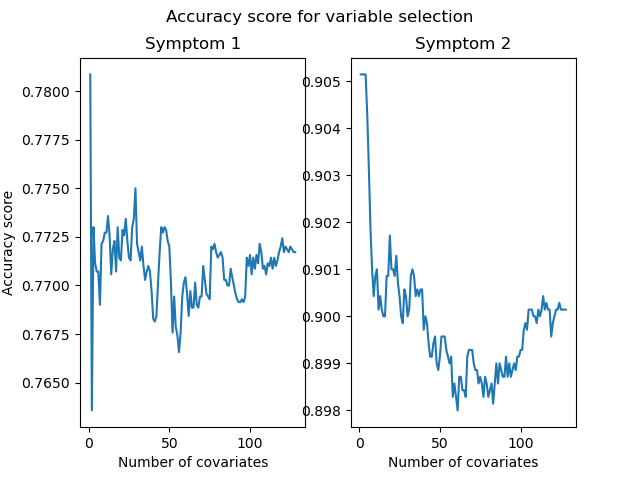

In [11]:
display(Image(filename="img/var_sel.png", width = 600))

##### Hierarchical model

Now let us observe the problem of a single vs multiple cause model from the Bayesian perspective. The relationship we are interested in is given by $y_t | a_t$, that is, how is the outcome for the observation dependent on the intervention ($a_t$). Before we can do this, we would like to consider the causes for the symptoms $x_{129}$ and $x_{130}$. This can be considered as a hierachical model in the Bayesian framework. If we look at a model posterior, we have

$$
\phi (\mu_i | \vec{y}) = \frac{P(\vec{y} | \mu_i) \phi (\mu_i)}{\sum_{i} P(\vec{y} | \mu_i) \phi (\mu_i)}
$$

for a model $\mu_i$, adapted from (Dimitrakakis, 2020, p. 98). The problem we then have is to specify a prior for the different models, this could for example be a noninformative prior (e.g. uniform) if we have no specific information to suggest otherwise prior to selecting the models. For simplicity, we define the single-cause models as having one covariate and the multiple-cause model as having all the covariates. In our case, we then have 129 different models for each of the symptoms. If we consider the different models as being different logistic regression using the different covariates we could define the structure

$$
\eta_t(\vec{x}_t) = \beta_0 + \vec{\beta}^{T}\vec{x}
$$

further, this would give the conditional probability

$$
Pr(ys_t = 1 | x = x_t) = \frac{e^{\eta_t(\vec{x}_t)}}{1 + e^{\eta_t(\vec{x}_t)}}
$$

adapted from (Hastie et al., 2016, p. 119). Where $ys_t$ is the symptom response for observation $t$. After calculating the model, we would then have $P(\vec{y} | \mu_i)$, the likelihood of the observed data given the model $\mu_i$. Obviously, we do not know $\phi(\mu_i)$, so we use a subjective probability distribution $\xi$ (Dimitrakakis, 2020, p. 108) as an estimator of the true (unknown) $\phi$.

The symptom response $ys_t$ is then Bernoulli distributed with parameter $\eta_t(\vec{x}_t)$. If we call

$$
Pr(ys_t = 1 | x = x_t) = p_t
$$

the likelihood can then be written

$$
l(\vec{\beta}) = \prod_{i=1}^{n} p_t^{ys_t} \cdot (1-p_t)^{1-ys_t} 
$$

which has log-likelihood

$$
loglik(\vec{\beta}) = \sum_{i=1}^{n} ys_t log(p_t) + (1-ys_t) log(1 - p_t)
$$

adapted from (Hastie et al., 2016, p. 120). This will provide us with the opportunity of calculating the likelihood of the data given the different models which then again will allow us to calculate the posterior probability of the different models. 


Plotting the posterior probabilities for symptom 1

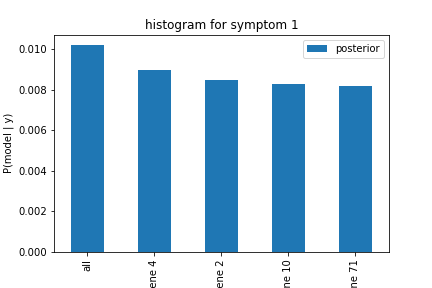

In [12]:
display(Image(filename="img/histogram_for_symptom_1.png", width = 600))

Plotting the posterior probabilities for symptom 2

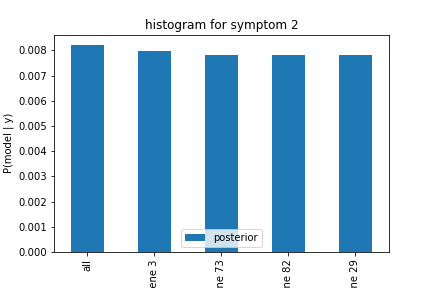

In [13]:
display(Image(filename="img/histogram_for_symptom_2.png", width = 600))

From the plots of the posterior probability for the model, we see that the full model has the highest posterior probability of the different models. We see that the single covariates 'gene 4' and 'gene 3' are the models with the highest posterior probability for symptom 1 and symptom 2 respectively. This seems to support the accuracy score from the part above. However these results were found by simply fitting models to the data and calculating their likelihood, as opposed to using a fully bayesian approach. Which means that we should be using train and test set to make sure that we are not overfitting. Below are the results using cross validation.

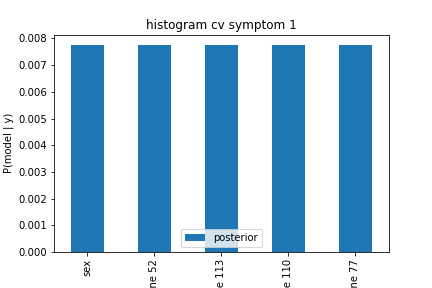

In [14]:
display(Image(filename="img/histogram_cv_symptom_1.png", width = 600))

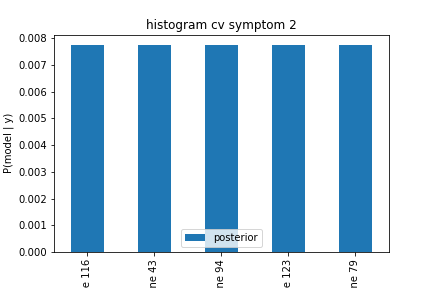

In [15]:
display(Image(filename="img/histogram_cv_symptom_2.png", width = 600))

#### Factors that may be important for disease epidemiology
The analyses we have performed so far seem to indicate that a multiple cause model is more likely. Allthough our variable selection procedure determined that single cause models were the best performing, the differnce in performance between the best performing model and the full model was small in absolute terms. The hypothesis testing of our logistic regression parameters, our K-modes clustering, and our hierarchical models all suggest that there are multiple covariates responsible for the symptoms. Which covariates these are our results disagree on. The full logistic regression suggests a handful of genes, while the hierarchical models suggest all covariates play a part. This result discrepancy could be due to the fact that the hierarchical models only tested all covariates for the multiple cause case. Our results also seem to indicate that certain genes, namely 2,3,4,60, and 99, play an important role in disease epidemiology. Further study of these genes in particular is warranted. Going forward we will be using a full model with all our covariates due to the evidence we have found in favour of a multiple cause model.

In an ideal world, we would know if we found a sufficient covariate for the outcome $y_t$. This would imply that the outcome would be conditionally independent of the policy given this covariate and the action $a_t$ (Dimitrakakis, 2020, pp. 137-138). Intuitively, if we knew that for example 'gene 3' was the sufficient covariate, we would need only to check this covariate for the different observations. 

More likely is maybe the case where one of the covariates found above is an instrumental variable? In this case, the instrumental variable is a "representation" of the underlying/latent variable that affects both the outcome $y_t$ and the action $a_t$ (Dimitrakakis, 2020, p. 138). If this instrumental variable is possible to measure it could still function as a proxy for the sufficient variable (which may be unobservable).

### Measuring the effect of actions

We now need to look into the action $a$ and the outcome $y$ followed by this action. Intuitively, what we would like to measure is $y_t | a_t$, that is, the outcome given the different actions (in this case therapeutic intervention). If we define $y_t = 1$ to be a positive outcome (positive outcome) and $y_t = 0$ a negative outcome (no effect of action). Then we could define $a_t = 0$ to be placebo (no intervention) and $a_t = 1$ to be the intervention/medication.

When looking at the outcome variable $y_t$ we could think of this as a Bernoulli distributed variable when $a_t$ is given. We could then look at the estimator for the utility of a policy given an action $a_t$. We then have

$$
\hat{E} (U|a_t = a) = \frac{\sum_{t \in a_t = a} U(a_t, y_t)}{|a_t = a|}
$$

adapted from (Dimitrakakis, 2020, pp. 140-141). For simplicity, we assume that we have an utility function $U(a_t = 1, y_t = 1) = 1$ which is, the observation were given a treatment ($a_t = 1$) and it did have a postive effect ($y_t = 1$). On the other hand $U(a_t = 1, y_t = 0) = 0$, the utility for treated observations which still has symptoms.

Similarily for those observations that got placebo treatment $a_t = 0$. This gives the following

$$
\begin{aligned}
U(a_t = 1, y_t = 1) = 1 \\
U(a_t = 1, y_t = 0) = 0 \\
U(a_t = 0, y_t = 1) = 1 \\
U(a_t = 0, y_t = 0) = 0
\end{aligned}
$$

This approach will simply look at the action $a$ and the outcome $y$ from the action. So this measurement will only check $y_t | a_t$ independent of the historical data $x_t$. So in a sense it is only measuring the action $a_t$ independently of the previous condition (symptoms) in $x_t$.

I then implemented the method

In [16]:
def measure_effect(self, action):
        """Calculates the measured effect of an action.

        Args:
            action: 1 for treatment and 0 for placebo

        Returns:
            The measured effect.
        """
        y_joined = [self.y_train, self.y_test]
        y = pd.concat(y_joined)
        y_array = self._to_flat_array(y)

        a_joined = [self.a_train, self.a_test]
        a = pd.concat(a_joined)
        a_array = self._to_flat_array(a)

        return self._utility(a_array, y_array, action)

with the (private) helper method

In [17]:
def _utility(self, a, y, at):
        """Calculates utility.

        Args:
            a: action array
            y: outcome array
            at: action to measure utility for

        Returns:
            Utility for observation.
        """
        num_at = len(np.where(a == at)[0])
        u = 0

        for i in range(len(a)):
            if a[i] == at and y[i] == 1:
                u += 1

        return u/num_at

running this on the entire dataset gave expected utility from the treatment $a_t = 1$ to be $\approx 66$ times larger than the expected utility from the placebo $a_t = 0$.

From the fact that the expected utility for active treatment is higher than the expected utility from the placebo, it could indicate that the active treatment should be recommended. We try to separate the 'symptom 1' cases from the 'symptom 2' cases. We then want to examine the expected utility of active treatment ($a_t = 1$) versus placebo ($a_t = 0$) and condition on the symptom. Trying to find this out, we implemented the following method

In [18]:
def measure_effect_symptom(self, action, symptom):
        """Calculates the measured effect of an action.

        Args:
            action: 1 for treatment and 0 for placebo
            symptom: separate observations based on symptom

        Returns:
            The measured effect.
        """
        y_joined = [self.y_train, self.y_test]
        y = pd.concat(y_joined)
        y_array = self._to_flat_array(y)

        a_joined = [self.a_train, self.a_test]
        a = pd.concat(a_joined)
        a_array = self._to_flat_array(a)

        x_joined = [self.x_train, self.x_test]
        x = pd.concat(x_joined)

        if symptom == 1:
            sym_idx = x.iloc[:, -2] == 1
        else:
            sym_idx = x.iloc[:, -1] == 1

        a_cond_sym = a_array[sym_idx]
        y_cond_sym = y_array[sym_idx]

        return self._utility(a_cond_sym, y_cond_sym, action)

and got the following results (for the entire dataset):

E(U|a_t = 0, sym = 1) = 0.01427469135802469

E(U|a_t = 1, sym = 1) = 0.5964479526393686

E(U|a_t = 0, sym = 2) = 0.008955223880597015

E(U|a_t = 1, sym = 2) = 0.5956112852664577

this could maybe indicate that the active treatment has an effect in all the observed cases because the expected utility is relatively higher for the active treatment than placebo?

Due to the exceedingly greater expected utility of the intervention compared to the placebo, there is reason to expect the intervention to affect the outcome of an illness.

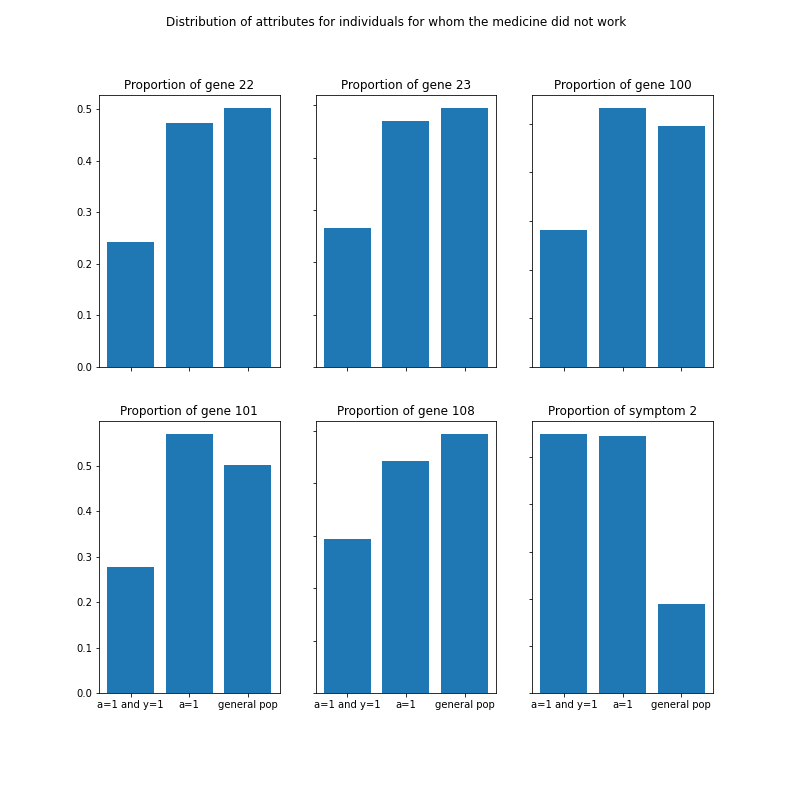

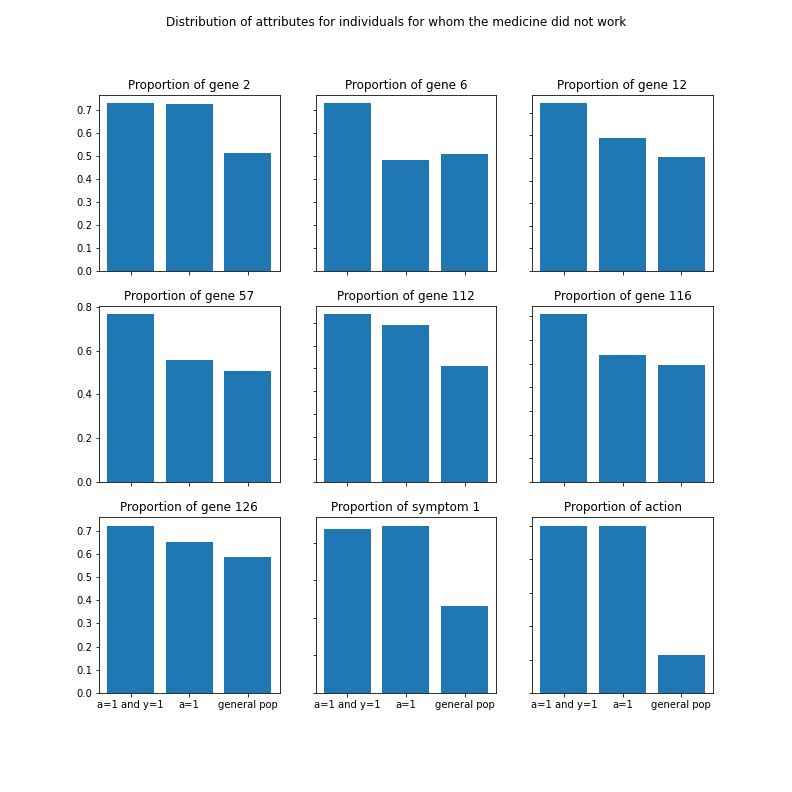

In [19]:
display(Image(filename="./img/proportion_diff_03.png", width = 600))
display(Image(filename="./img/proportion_diff_07.png", width = 600))

#### When should treatment not be given

We observe that there is an overrepresentation of some genes and an underrepresentation of others in the population $a=1\cap y=0$ compared to both the general population and $a=1\cap y=1$. We see little differences in the prevalence of the symptoms or the representation of sex or gender. These results imply that certain genes in their presence or absence contribute to the fact that the intervention does not work. This might be due to these genes causing or contributing to a different disease than the one targeted by the intervention, or that they interfere with the effect of the intervention in some way. Since interventions have costs and risks attached, the presence or absence of these genes should make one more hesitant to administer the intervention despite the expected utility reported earlier. A caveat of these findings is that they do not take into account higher order interactions between the genes, and should be taken with a pinch of salt.

## Part 2: improved policies


### Exercise 1

In this exercise we will use the assumptions and the utility function from the exercise text

$$
a_t \in \{0, 1\}
$$

where 0 is placebo and 1 is treatment and

$$
y_t \in \{0, 1\}
$$

where 0 is no effect and 1 is effect (assumed positive). The utility function as defined

$$
U(a_t, y_t) = -0.1a_t + y_t
$$

The current policy ($\pi_0$) which the medical data comes from is unknown. What we know about the policy $\pi_0$ however, is that it assigns either $a_t = 0$ or $a_t = 1$.

To say anything about the utility of a policy, we must define what the expected utility is. We can use the following

$$
E^{\pi}_{\theta}[U] = \int \sum_{a} \pi(a | x) \sum_{y} P_{\theta} (y | x, a) U(a, y) dP_{\theta} (x)
$$

adapted from (Dimitrakakis, 2020, p. 141). Further, it is possible to estimate this integral by using a form of Monte-Carlo estimation 

$$
E^{\pi}_{\theta}[U] \approx \frac{1}{n} \sum_{i=1}^{n} \sum_{a} \pi (a|x_t) \sum_{y} P_{\theta} (y | a, x_t) U(a, y)
$$

adapted from (Dimitrakakis, 2020, pp. 141-142). The approximation above can then be used in order to estimate the expected utility.

#### Measuring the utility of the historical policy on the historical data

##### Approach 1: direct calculation

Provided that we now have the actions, $a_t$, for the different observations $t$ and we have a function for calculating utility based on $a_t$ and $y_t$ it would be possible to calculate the utility directly. In this case we know there is a historical policy $\pi_0$ which was used in order to create the actions. This could be represented as 

$$
\pi_0 (a_t | x_t)
$$

the exact policy $\pi_0$ is still unknown to us, but we have observed the provided $a_t$ values, so how the decisions were taken by the policy would not necessarily affect our utility calculation. This implies that we could calculate the total utility as 

$$
U = \sum_{t=1}^{T} U(a_t, y_t)
$$

and the average utility as

$$
u = \frac{1}{T}\sum_{t=1}^{T} U(a_t, y_t)
$$

for this specific case

$$
u = \frac{1}{T}\sum_{t=1}^{T} U(a_t, y_t) \approx 0.1191
$$

this gave an average utility of 0.1191 over all the historical data.

##### Approach 2: expected utility

If we attempt to estimate the expected utility integral above, we could get a more detailed overview of the utility of the policy $\pi_0$. 

###### Simplification: model 0
As a simplification, we assume that the action $a_t$ is independent of the personal information of the individual observations, $x_t$. The outcome ($y_t$) however, we assume depends on the action $a_t$. We could then express this situation as 

$$
\begin{aligned}
a_t \sim Bernoulli(\pi_0) \\
y_t | a_t \sim Bernoulli(\theta_a)
\end{aligned}
$$

adapted from (Dimitrakakis, 2020, p. 146). In this situation, the action $a_t$ is Bernoulli distributed with parameter $\pi_0$ correspondning to our historical policy. Further, the outcome (whether or not the observation had measurable effect) will depend on the action $a_t$, again as a Bernoulli distributed random variable. Intuitively, we would expect that when active treatment is provided ($a_t=1$), the probability of effect ($y_t=1$) is higher. Typically, we would then expect that $\theta_1$ should be weighted in favor of $y_t = 1$.

A possible estimator for the parameter $\pi_0$ is the fraction of $a_t = 1$ in the historical data. This would then imply that $\hat{\pi}_0 = \frac{\sum_{t}^{n} I(a_t = 1)}{n}$, which could be estimated from the data.

In order to estimate the Bernoulli parameter $\theta_a$, we can used the maximum likelihood estimator for the variable 

$$
\hat{\theta}_a = \frac{\sum_{t} y_t \cdot I(a_t = a)}{\sum_{t} I(a_t = a)}
$$

adapted from (Dimitrakakis, 2020, p. 143). Once we have estimated $\theta_a$, we could sample from $Bernoulli(\pi_0)$ in order to get the $a_t$, then we could use $\theta_a$ in order to sample from $y_t | a_t$. In this case, $\theta_a | a_t$ is a conditional variable.

The posterior distribution for $a_t$ would then be

$$
p(a_t | y_t) \propto p(a_t) p(y_t | a_t)
$$

and from this posterior distribution, we can sample pairs of ($a_t, y_t$) created with the approximate policy $\hat{\pi}_0$. We calculate the expected utility after sampling from the 'model 0' above with $\pi_0$ and $\theta_a$ from the historical policy.


Assuming model 0 it is also possible to calculate the expected value of the utility analytically. For doing this we will be using the fact that

$$
E[Y] = E[E[Y|A]] = \sum_{a_t} E[Y|A=a_t] \cdot P(a_t)
$$

adapted from (Devore & Berk, 2012, p. 261). This allows us to calculate the expected utility of a single observation analytically. Using the provided function from the exercise text we get

$$
\begin{aligned}
E[U] = E[\sum_{t} r_t] = \sum_{t} E[r_t] \\
= \sum_{t} E[-0.1 a_t + y_t] \\
= \sum_{t} -0.1E[a_t] + E[y_t] \\
\end{aligned}
$$

in this model, $y_t$ is dependent on $a_t$, we then have to use the expected value of $y_t$ conditioned on $a_t$. This gives

$$
E[y_t] = E[E[y_t | a_t]] = \sum_{a_t} E[y_t | a = a_t] P(a_t)
$$

proceding and looking at a single observation we get 

$$
E[U_t] = -0.1E[a_t] + \sum_{a_t} E[y_t | a = a_t] P(a_t)
$$

further, we know that a Bernoulli distributed variabel $x$ has $E[X] = p(X = 1)$ (Devore & Berk, 2012, p. 113). Utilizing this together with the estimates $\hat{\pi}_0$ and $\hat{\theta}_a$ that (estimated from historical data) is

$$
\begin{aligned}
\hat{\pi}_0 = 0.2298 \\
\hat{\theta}_a = (\theta_0, \theta_1) \approx (0.008959, 0.588338)
\end{aligned}
$$

which means that

$$
\begin{aligned}
E[U_t] = -0.1E[a_t] + (E[y_t | a = 0]P(a = 0) + E[y_t | a = 1]P(a = 1)) \\
E[U_t] = -0.1 \cdot 0.2298 + (0.008959 \cdot 0.7702 + 0.588338 \cdot 0.2298) \\
\hat{E}(U_t) \approx 0.119120
\end{aligned}
$$

We can also use the expression for the expected utility

$$
E[U] = \sum_{a} \pi (a) \sum_{y} P(y|a)U(a,y)
$$

adapted from (Dimitrakakis, 2020, p. 141). This gives

$$
\begin{aligned}
E[U] = \pi (a = 0) \cdot (P(y=0 | a=0)U(a=0,y=0) + P(y=1 | a=0)U(a=0,y=1)) + \\
\pi (a = 1) \cdot (P(y=0 | a=1)U(a=1,y=0) + P(y=1 | a=1)U(a=1,y=1)) \\
\approx 0.1191
\end{aligned}
$$

given that $\hat{\pi}_0$ and $\hat{\theta}_a$ is estimated from the historical data, it is intuitively reasonable that the expected utility based on this approach is similar to the historical average utility.

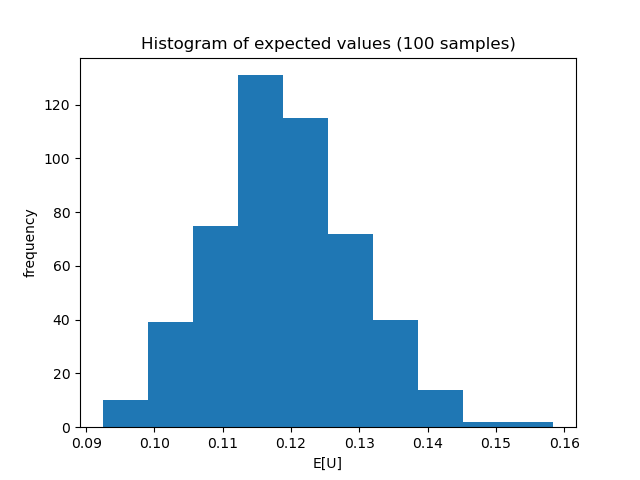

In [20]:
display(Image(filename="img/part2_1_method0_hist.png", width = 600))

###### Simplification: bootstrap approach

Another approach for estimating error bounds for the expected utility is nonparametric bootstrap. We already have a large sample, so the central limit theorem is already affecting the calculation of the expected utility. 

In general, we would sample with replacement from the relevant pairs of data. The samples would be the same size as the original dataset. Then we use each of the sampled dataset to calculate $\hat{\theta}$ and then we have a "distribution" of $\hat{\theta}$. This "distribution" can then be used to estimate different quantities of interest (Hastie et al., 2016, p. 249). We can use this general idea and define $\hat{\theta}$ as the expected utility. In this way we can estimate a variance for the expected utility. This would intuitively describe error bounds on the expected utility as it describes the fact that the sample of observations is just that, a sample from the true, unknown, population of observations.

The bootstrap expected utilities can be seen in the histogram below


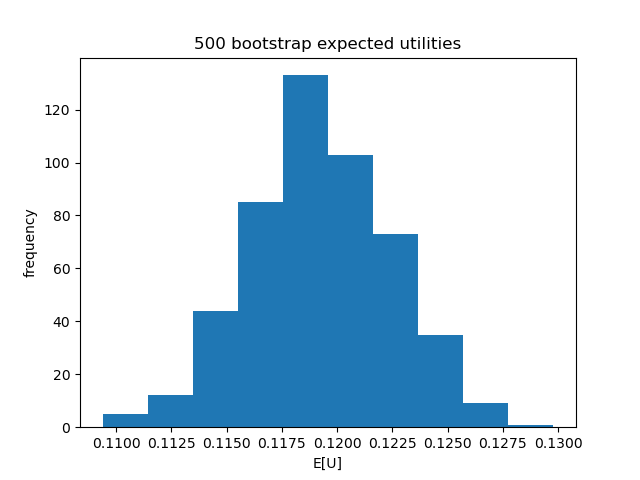

In [21]:
display(Image(filename="img/part2_1_bootstrap_hist.png", width = 600))

Specifically, we see that the histogram of expected utilities is relatively narrow compared to the histogram from the model 0 above.

#### Error bounds for expected utility

##### Methodologies compared

##### 1. Percentile intervals

We could base our approximation of the error bounds on the percentile interval, commonly used within bootstrap methods. This would involve calculating the approximated expected utility, which is a mean of the expected values, then we would selct the $i_B = \frac{\alpha (n_B + 1)}{2}$ from the two ends of the sorted array of estimates in order to get the $100(1-\alpha)\%$ percentile interval (Devore & Berk, 2012, p. 414). For the expected utility, this would involve calculating $n_B$ expected utilities and then looking at the percentile interval at for example $95\%$.

##### 2. Bootstrap confidence intervals

Looking at the histogram above, it could resemble an approximation to a normal distribution. The central limit affect the distribution of the means when $n \rightarrow \infty$ and ensures approximate normality in the distribution of the means (Devore & Berk, 2012, p. 298). This we can utilize further when attempting to estimate error bounds. The CLT allows us to use critical values from the normal distribution quantiles together with an approximation to the variance of the mean in order to estimate the confidence interval. This approximation to the variance of the mean is given as

$$
\hat{\sigma}^2 = \frac{1}{n_B - 1} \sum_{i = 1}^{n_B} (\bar{x}^{*}_i - \bar{x}^{*})^{2}
$$

adapted from (Devore & Berk, 2012, p. 413). This, together with the critical value for the quantile allows us to create an error bound for the expected utility.

##### 3. Estimating analytical variance when using simplification model

In simplification cases where the data is assumed to follow a certain distribution this enables us to calculate the empirical variance based on the simplified model. This method for estimating error bounds depends on the model that is assumed to represent the data.

##### 4. Confidence interval from Hoeffding's inequality

Since we are looking at the expected (mean) utility, then it might be that we can look at the following inequality that holds with $Pr = 1-\alpha$

$$
| \bar{r} - E[U] | \le \frac{1}{\sqrt{2n}} \sqrt{\frac{ln(2)}{\alpha}}
$$

where $n$ is the number of observations, adapted from (Dimitrakakis, 2020, p. 58). Then we could say that the error bound from the true (unknown) expected utility is approximately the expression on the RHS above.

##### 5. Bounded deviations for expected value of policy

We also found a lecture that described deviations of expected value (expected utility in our case) for a policy. The lecture defined the deviations as being 

$$
\propto \frac{1}{\sqrt{n p^{*}(x)}}
$$

where $p^{*}$ seems to be the smallest probability of an action given an observation, adapted from (Langford, 2017).


##### Model 0

##### method: percentile interval

The error bounds below is adapted from Dirk's code from lecture 10 (Github, 2020). From it we se the expected utility as circles while the error bounds are based on the 2.5 and 97.5 percentile. The sampling is repeated as many times as there are error bounds shown below. The expected (mean) utility seems to be close to the historical utility.

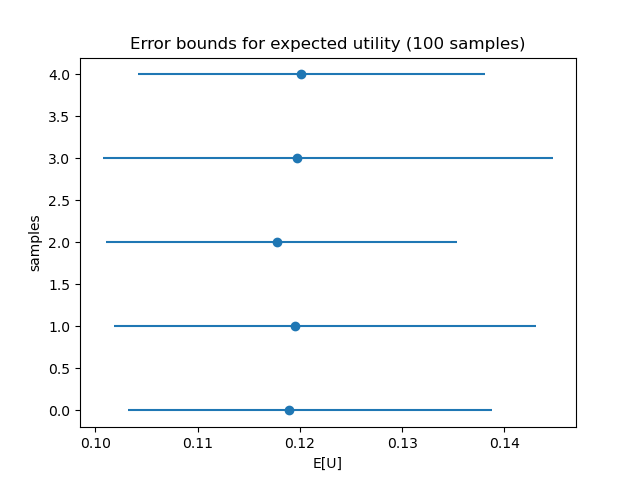

In [22]:
display(Image(filename="img/part2_1_method0_error.png", width = 600))

This plot shows the expected value as the circles and the different samples along the y-axis. We also see from the previous point that the historical utility calculated from the original historical data is included in the different percentile intervals based on the sampled data from the posterior distribution of $a_t$.

##### method: bootstrap confidence interval

Testing the bootstrap confidence interval approach gave the following when using the critical value $z_{0.025} = 1.96$ for a 95 % bootstrap confidence interval.


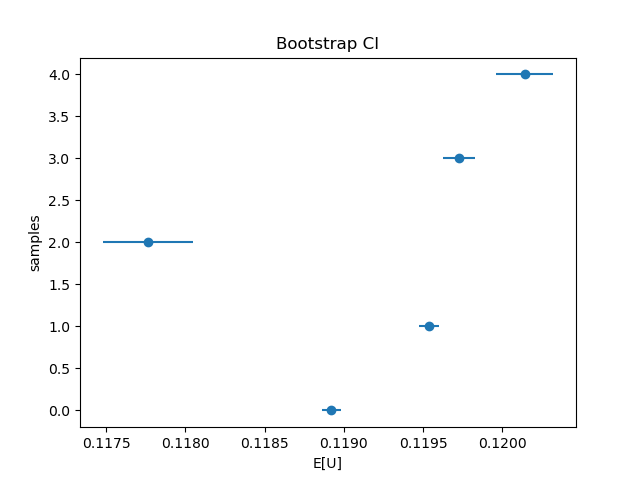

In [23]:
display(Image(filename="img/part2_1_method0_bootci.png", width = 600))

From the bootstrap confidence interval, we see that the expected utiity also with this case is relatively close to the historical expected value $\approx 0.1191$

##### method: analytical variance using reward expression

We can calculate the empirical variance of the utility based on the simplified model. Given that we assume $a_t$ and $y_t$ as Bernoulli variables, we can calculate the variance of the utility function (equal to reward $r_t$ for a single observation). We have from the section above that 

$$
E[r_t] \approx 0.119120
$$

and we can now estimate $V[r_t]$, given model 0. This implies we can create an approximated confidence interval 

$$
E[r_t] \pm z_{\frac{\alpha}{2}} \frac{s}{\sqrt{n}}
$$

adapted from (Devore & Berk, 2012, p. 392). We then want to estimate $V[r_t]$, we want to use the fact that $y_t | a_t$ and we then get

$$
V[r_t] = V[-0.1 a_t + y_t] = (-0.1)^2 V[a_t] + V[y_t]
$$

Because the variance of a Bernoulli distributed variable $X$ is $V[X] = P(X=1) \cdot (1 - P(X=1))$, adapted from (Devore & Berk, 2012, p. 308) we have that

$$
V[a_t] = P(a_t = 1) \cdot (1 - P(a_t = 1)) \\
= \hat{\pi}_0 \cdot (1 - \hat{\pi}_0)
$$

which we have estimated values for in the section about expected values.

In order to estimate the variance of $y_t$, we use the following relation 

$$
V[y_t] = V[E[y_t|a_t]] + E[V[y_t|a_t]]
$$

adapted from (Devore & Berk, 2012, p. 261) in order to calculate the variance of $y_t$. We can the calculate the two terms, starting with the expected value of the conditional variance

$$
\begin{aligned}
E[V[y_t|a_t]] = V[y_t|a_t = 0]P(a_t = 0) + V[y_t|a_t = 1]P(a_t = 1) \\
= P(y_t = 1 |a_t = 0) \cdot (1 - P(y_t = 1 |a_t = 0)) \cdot P(a_t = 0) + P(y_t = 1 |a_t = 1) \cdot (1 - P(y_t = 1 |a_t = 1)) \cdot P(a_t = 1) \\
= \hat{\theta}_0 \cdot (1 - \hat{\theta}_0) \cdot (1 - \hat{\pi}_0) + \hat{\theta}_1 \cdot (1 - \hat{\theta}_1) \cdot \hat{\pi}_0 \\
= 0.0090 \cdot (1 - 0.0090) \cdot (1 - 0.2298) + 0.5883 \cdot (1 - 0.5883) \cdot 0.2298 \\
\approx 0.0625
\end{aligned}
$$

then we can calculate the variance of the conditional expected value, calling $E[y_t|a_t] = X$ and $E[E[y_t|a_t]] = \mu$ and use the equation for variance expressed as an expectation value (Devore & Berk, 2012, p. 173), this then gives

$$
\begin{aligned}
V[E[y_t|a_t]] = V[X] = E[(X - \mu)^2] \\
= (E[y_t|a_t = 0] - \mu)^2 P(a_t = 0) + (E[y_t|a_t = 1] - \mu)^2 P(a_t = 1) \\
= (0.0090 - 0.1421)^2 \cdot (1 - \hat{\pi}_0) + (0.5883 - 0.1421)^2 \cdot \hat{\pi}_0 \\
\approx 0.0594
\end{aligned}
$$

we then have from the section above that 

$$
\begin{aligned}
E[E[y_t|a_t]] \approx 0.1421 \\
E[y_t|a_t = 0] \approx 0.0090 \\
E[y_t|a_t = 1] \approx 0.5883
\end{aligned}
$$

now we can substitute this into the first relation

$$
V[y_t] = 0.0594 + 0.0625 \approx 0.1219
$$

and then we can estimate the variance for the reward $r_t$

$$
\begin{aligned}
V[r_t] = V[-0.1 a_t + y_t] = (-0.1)^2 V[a_t] + V[y_t] \\
= (-0.1)^2 \cdot 0.2298 \cdot (1 - 0.2298) + 0.1219 \\
\approx 0.1237
\end{aligned}
$$

now we are able to estimate an approximate 95 % confidence interval

$$
\begin{aligned}
E[r_t] \pm z_{\frac{\alpha}{2}} \frac{s}{\sqrt{n}} \\
0.1191 \pm 1.96 \frac{\sqrt{0.1237}}{\sqrt{10000}} \\
[0.1122, 0.1260]
\end{aligned}
$$


We can also try to estimate the variance with using the $E[U]$ expression

$$
\begin{aligned}
E[U] = \sum_{a} \pi (a) \sum_{y} P(y|a)U(a,y) \\
\approx 0.1191
\end{aligned}
$$

adapted from (Dimitrakakis, 2020, p. 141). If we assume that the utility $U$ is independent we can check the variance with the classical relation

$$
V[U] = E[U^2] - (E[U])^2
$$

from (Devore & Berk, 2012, p. 173). We then check

$$
\begin{aligned}
E[U^2] = \sum_{a} \pi (a) \sum_{y} P(y|a)(U(a,y))^2 \\
\approx 0.1173
\end{aligned}
$$

and then 

$$
\begin{aligned}
V[U] = 0.1173 - 0.1191^2 \approx 0.1031
\end{aligned}
$$

using this in the same way as for $E[r_t]$ we have

$$
\begin{aligned}
E[U] \pm z_{\frac{\alpha}{2}} \frac{\sqrt{V[U]}}{\sqrt{n}} \\
0.1191 \pm 1.96 \frac{\sqrt{0.1031}}{\sqrt{10000}} \\
[0.1128, 0.1254]
\end{aligned}
$$


Just from visual comparison, this confidence interval seems to correspond fairly well with the bootstrap confidence interval and the histogram of expected utilities in the section above.

##### method: confidence based on Hoeffding's inequality

We try out this method briefly as we are not completely sure of its applicability. We know from model 0 above that the mean $\bar{r} \approx 0.1191$ based on $n = 10000$. Say we set $\alpha = 0.05$, then:

$$
\bar{r} \pm  \frac{1}{\sqrt{2 \cdot 10000}} \sqrt{\frac{ln(2)}{0.05}}
$$

which gives $\approx$ the interval

$$
[0.0928, 0.1454]
$$

This interval is approximately equal in size as the $\alpha = 0.05$ percentile intervals above.

##### Bootstrap approach

###### method: percentile interval

We can now use the percentile method in order to select percentile of the expected utilities from bootstrap samples. From the plot below, we see that the boostrap percentile intervals for a 95 % confidence interval are extremely similar across the repetitions.

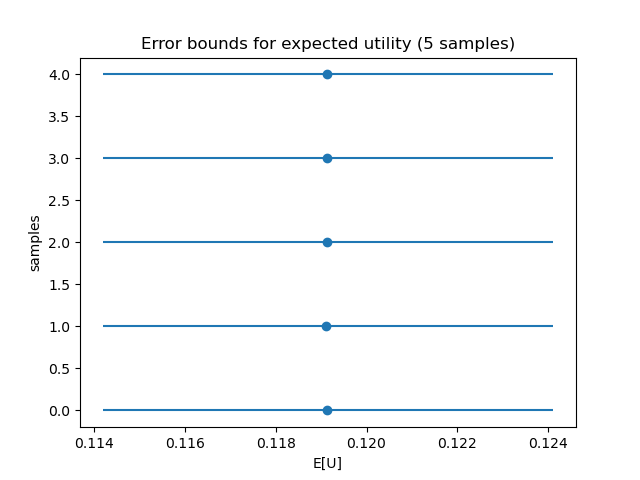

In [24]:
display(Image(filename="img/part2_1_bootstrap_percentile_ci.png", width = 600))

##### method: bootstrap confidence interval

We can also try with the bootstrap confidence interval as described above in order to establish error bounds on the expected utility. The bootstrap confidence intervals plotted below are also very similar across the repetitions. This is very noticable when comparing to the bootstrap confidence interval when model 0 is assumed to be correct.

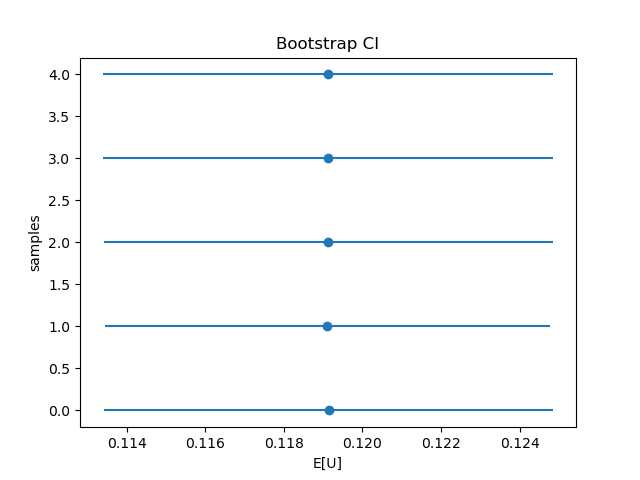

In [25]:
display(Image(filename="img/part2_1_bootstrap_bootstrap_ci.png", width = 600))

### Exercise 2

We have the data from the exercise which we assume is retrieved using a null policy $\pi_0$. The null policy in this case is unknown, but we must assume it is the foundation for the existing data set. This we have to do in order to measure possible interventions through new policies $\pi \in \Pi$ (Dimitrakakis, 2020, p. 139). In order to have an improved policy, we can look at direct intervention as a policy $\pi \in \Pi$ and then define a conditional distribution $\pi(a_t | x_t)$ as the new policy (Dimitrakakis, 2020, p. 140). This would mean that we have a conditional distribution for the action to take given the information $x_t$.

We will consider this clinical setting as a contextual bandit problem. We will assume that the observations $t = 1, ..., T$ arrive sequentially. This is a common contextual bandit setting where we can observe $x_t$ from each of the observation and then has to make a decsion $a_t$ (Chen et al., 2020). We will therefore also assume that the null policy $\pi_0$ has been performed in the same way (i.e. obtaining the observations sequentially). We will in the improved policy try to use contextual information ($x_t$) in order to improve the policy.

Selecting the action of the estimated expected reward $E[r_t | a_t = a]$ can in general be seen as a score predictor-policy, where we always choose the action maximizing this predicted score (Slivkins, 2019). When we select the action giving the highest estimated expected reward, we are basing this decision on the context of the observation $x_t$ and a predefined model. If the "new" data we observed is relatively similar to the data we used to estimate the model (and therefore is using to select the best action) we would expect to see an increase in estimated expected reward/utility. On the other hand, if the data is changing over time $t \rightarrow \infty$, we are basing our decision on potentially very different data than the current. This static setting may therefore be vulnerable to changing data.

The situation of having observations $(\vec{x}_t, a_t, y_t)$ in which the outcome $y_t | \vec{x}_t, a_t$ can be considered a Bandit problem. We then assume that the observations $t \in [1, T]$ are observed sequentially, and we have to decide for an action $a_t$ after observing $\vec{x}_t$. That is, we have to decide for placebo $a_t = 0$ or treatment $a_t = 1$ after seing the covariates for each observation $\vec{x}_t$. From historical data, we can then also see the action $a_t$ that was chosen for the particular observation and the outcome of that treatment for that observation ($y_t$).

In a general setting, we would also have to consider the fact that we may not select the best action based on our policy in the long term, even though it is the action that maximizes the expected reward. In order to detect the potentially better actions, we could use algorithms like the $\epsilon$-greedy algorithm, which imply that it might be beneficial to select the "not-optimal" action sometimes in order to learn (Dimitrakakis, 2020, p. 154). This algorithm could then be described as

$$
\hat{\pi}_{\epsilon} = (1 - \epsilon) \hat{\pi} + \epsilon \cdot a^{*}
$$

where $a^{*}$ is a randomly selected action choosen in order to explore the reward of other actions than the one selected by the policy, adapted from (Dimitrakakis, 2020, p. 154). We also see that selecting $\epsilon = 0$ is equal to always selecting the action $a_t$ that maximizes expected reward, which is what we are doing in the 'ImprovedRecommender' situation.

#### Upper confidence bound algorithm

The $\epsilon$-greedy algorithm has some flaws, namely it is not smart about which action it explores but rather picks one at random. The Upper Confidence Bound algorithms is a family of algorithms that is able to balance exploration and exploitation better, and also be smarter about where it explores. It is based on not only computing the expected reward for each arm, but also estimate an upper confidence bound through the Hoeffding’s Inequality and choosing the arm that maximizes this upper confidence bound.

$$
a_t = \text{argmax}_a r_{t, a} + \alpha \sqrt{\frac{2\ln(t)}{m_a}}
$$

where $r_{t, a}$ is the reward for observation $t$ given action $a$, $m_a$ is the number of times we have chosen action $a$ so far and $\alpha$ is a constant calculated by $\alpha = 1 + \sqrt{\frac{\ln(2/\delta)}{2}}$ and $\delta$ is a chosen, reasonably small probability.

The confidence interval widens as $t$ increases, but shrinks as $m_a$ increases. This ensures that as $t$ approaches infinity, each action is picked 	infinitely many times, while still maintaining a good exploration, exploitation balance.

#### Contextual bandit problem

The contextual bandit can then attempt to utilize the observed context $\vec{x}_t$ in order to select the (expected) best action $a_t$. For an adaptive setting (part 3) we can also see if adding observations (data, action, outcome) to our model can help improve the prediction of the best arm. The general algorithm can be summarized as:

for t = 1, ..., T
1. the recommender observes $\vec{x}_t$ (the context) and the recommender is aware of its actions $a_t \in A$. So the information available at this stage is ($\vec{x}_t$, $a_t$)
2. an action $a_t$ is selected conditioned on the context, so $\pi(a_t | x_t)$
3. we can observe the outcome of our action (in an adaptive setting), so if we select $a_t = a^*$, we can observe ($x_t$, $a_t=a^*$, $y_t$) in adaptive recommendation settings

adapted from (Li et al., 2010). We see that if we are able to observe the outcome (effect/no effect) from our actions (placebo/active treatment), we can use this information to further improve our recommender.


#### Approach 1 structure

In order to explore different models for the data easily, the approach 1 is structured as follows (visualized with a pseudo UML-diagram). The RecommenderModel class represents the assumed model for the data used in the different recommenders, they control the estimation of $P(y_t | a_t, x_t)$ (predict_proba) and $\pi(a_t | x_t)$ (get_action_probabilities).


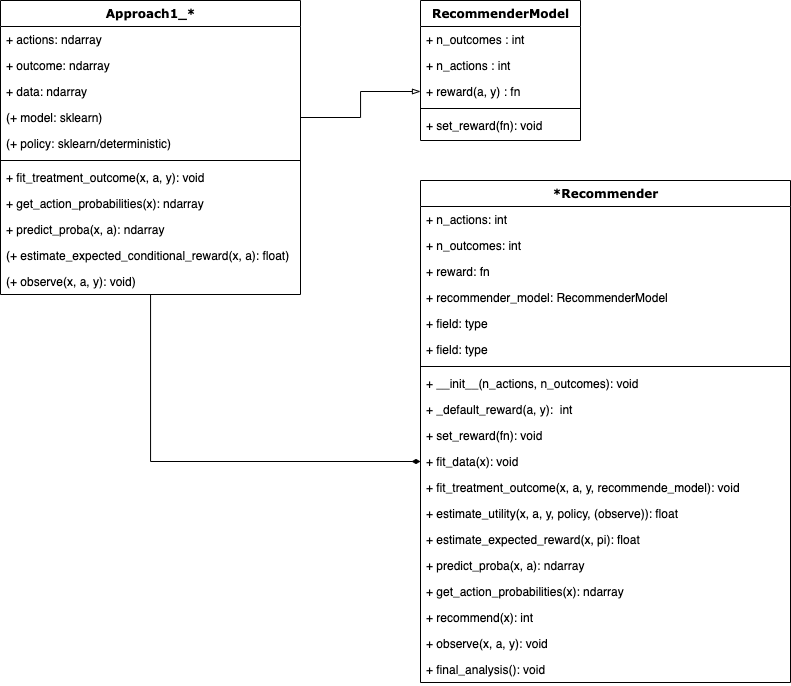

In [26]:
display(Image(filename="img/Approach1_structure.png", width = 600))

For the improved policy, we will first try to use the contextual information $x_t$ for each observation when deciding which action $a_t$ to use. We use the assumption from the exercise text that the policy can be seen as a conditional distribution $\pi(a_t | x_t)$. In order to use this we must define a model which should provide $\pi(a_t | x_t)$. One possibility is to use so-called warm-up samples in order to estimate our model. After the warm-up samples have been used to estimate the model, we can use the conditional distribution in order to estimate the conditional distribution (Chen et al., 2020). We can approach this problem in different ways.

#### Bernoulli-logistic regression models

We want to use some contextual information ($x_t$) in order to predict the outcome ($y_t$). If we can estimate the outcome, we can also choose the action ($a_t$) which gives the highest expected reward. We will use a logistic regression model fitted on all the covariates to estimate $E[y_t|a_t]$ and use the training set as the "warm-up" samples as the observatins should be independent w.r.t. order.

We then propose two different approaches to the logistic regression model:
  
**Approach 1** is to include $a_t$ as a covariate:

$$
\begin{aligned}
\eta_t = \hat{\vec{\beta}}^{T} \cdot (\vec{x}_t, a_t) \\
y_t \sim Bernoulli(logit^{-1}(\eta_t))
\end{aligned}
$$

$a$ should be represented through a one hot encoded attribute as the vaules for $a$ are arbitrary and only ment as an identifier for each tratment. 

**Approach 2** is to fit a seperate $\hat{\vec{\beta}}_t$ for each possible value of $a \in \mathcal{A}$:

$$
\begin{aligned}
\eta_t = \sum_{a \in \mathcal{A}} \hat{\vec{\beta}}_t^T \cdot \vec{x}_t \mathbb{I}(a_t = a) \\
y_t \sim Bernoulli(logit^{-1}(\eta_t))
\end{aligned}
$$

where $\mathbb{I}(z)$ is the indicator function giving 1 when $z$ is satisfied and 0 otherwise. This approach is equivalent to grouping the data by treatment and fitting an induvidual model for each new subset of the training data which should be simpler to implement.

We can then get an estimate of the reward $r_t|a_t$ by using our prediction of $y_t|a_t$ and select the action that maximises expected reward:

$$
\begin{aligned}
E[r_t | a_t = a] &= E[-0.1a_t + y_t] \\
&= -0.1a_t + E[y_t | a_t]
\end{aligned}
$$

the variable $y_t$ is Bernoulli distributed, so its expectation value is $p_t$ (its probability of being 1) from the section above.

$$
E^{\hat{\pi}}[r_t | a_t = a] = -0.1a_t + logit^{-1}(\eta_t)
$$

#### Expected utility

Now that we have suggested an improved policy $\hat{\pi}$, we can calculate the expected utility given a model trained on the historical data.

$$
\begin{aligned}
        E_\theta^{\hat{\pi}}[U]   & = E_\theta^{\hat{\pi}}[\sum_{t=1}^T r_t] = \sum_{t=1}^T E_\theta^{\hat{\pi}}[r_t] \\
        E_\theta^{\hat{\pi}}[r_t] & = E_\theta^{\hat{\pi}}[y_t - 0.1a_t] \\
                                  & = \sum_{a \in \mathcal{A}} E_\theta^{\hat{\pi}}[y_t - 0.1a_t | a_t=a] P_\theta^{\hat{\pi}}(a_t=a) \\
                                  & = \sum_{a \in \mathcal{A}} \left(E_\theta^{\hat{\pi}}[y_t | a_t=a]  - 0.1a \right) P_\theta^{\hat{\pi}}(a_t=a) \\
\end{aligned}
$$

This calculation is implemented in the estimate_utility() method of the recommenders. Below are the results from training the model on $2/3$ of the data and estimating utility on the rest.

In [27]:
import martin_improved_recommender
import chris_improved_recommender
np.random.seed(1)

approach1 = martin_improved_recommender.ImprovedRecommender(n_actions=2, n_outcomes=2)
approach2 = chris_improved_recommender.LogisticRecommender(n_actions=2, n_outcomes=2)

approach1.fit_treatment_outcome(x_train.values, a_train.values, y_train.values)
approach2.fit_treatment_outcome(x_train.values, a_train.values, y_train.values)

print(f"Approach 1 avarage expected reward: {approach1.estimate_utility(x_test, a_test, y_test)}")
print(f"Approach 2 avarage expected reward: {approach2.estimate_utility(x_test.values, a_test.values, y_test.values)}")

Fitting treatment outcomes
Estimating = 3000 observations
Approach 1 avarage expected reward: 0.5136564854279213
Approach 2 avarage expected reward: 0.5229388620778201


Approach 1 and 2 have an average expeceted reward of 0.50 and 0.52 respectively. It is not surprising that approach 2 is better, although I expected a bigger difference. Approach 2 is able to take into account that the effect of genes could be dependent on which treatment is given, but it appears that this is not hugely relevant.

## Part 3: adaptive experiment design

In the clinical trial setting we recieve feedback on the effects of the actions we choose. This corresponds to a "bandit feedback" which is the situation where we select a treatment $a_t = a$ and observe the outcome $y_t$, but we have no information about the outcome $y_t$ for $a_t \ne a$. This is the opposite to a situation where we would have "full feedback", that is, we would know the outcome $y_t$ for the same observation, but with another treatment ($a_t$) (Slivkins, 2019). For the observations, we will simplify and assume that they are i.i.d. so the reward conditional on the action $a_t$ will also be i.i.d. (Slivkins, 2019). Intuitively, in an adaptive experiment, we want to utilize information from new observations as they become available. This will be done in the 'observe' method of the recommender.

When considering the estimated expected utility for a policy $\pi$, we can use the fact that the utility in this case is the sum of the rewards for all the observations. To estimate the expected utility, we can then calculate the expected reward for each observation $t$ and then look at the total expected utility or the mean expected utility of the policy. One general approach to this is the following:

$$
\begin{aligned}
E^{\pi}[U] = \int \sum_{a} \pi(a | x) \sum_{y}P(y | x, a) U(a, y) dP(x) \\
\approx \frac{1}{T} \sum_{t=1}^{T} \sum_{a} \pi(a | x) \sum_{y}P(y | x, a) U(a, y)
\end{aligned}
$$

adapted from (Dimitrakakis, 2020, pp. 141-142). However, when presented with large enough amounts of new data we can calculate the utility directly and use it as an estimate of expected utility. Another important aspect of bandit problems is the one w.r.t. regret. This is typically defined as the difference between the expected reward of the policy that consists of always selecting the best action in expectation.

$$
\sum_{t=1}^{T} E^{b}[r_t] - E^{\pi}[r_t]
$$

where $E^{b}$ is the expectation for the best action at all $t$, adapted from (Dimitrakakis, 2020, p. 159). If our policy $\pi$ is influenced by a high $\epsilon$ we would expect that this difference is large, on the contrary, if the policy at all times selects the action with the largest expected reward, we expect the difference to be smaller.


### Exercise 3

### Approach 1

##### HistoricalRecommender

##### Bernoulli-Logistic regression

This policy model is a subclass of RecommenderModel and can be found in class: Approach1_hist_bl.

In order to estimate the historical policy $\pi_0$, we will assume for simplicity the model:

policy $\pi_0(a_t | x_t)$:
$$
\begin{aligned}
\eta_{a_t} = \hat{\vec{\beta}}^{T} \cdot \vec{x} \\
a_t \sim Bernoulli(logit^{-1}(\eta_{a_t}))
\end{aligned}
$$

distribution for the outcomes $P_{\theta}(y_t | a_t, x_t)$ parameterized with $a_t$ in the covariates:
$$
\begin{aligned}
\eta_{y_t} = \hat{\vec{\beta}}^{T} \cdot (\vec{x}, a_t) \\
y_t \sim Bernoulli(logit^{-1}(\eta_{y_t}))
\end{aligned}
$$

here, we will calculate the policy $\pi_0(a_t | x_t)$ and the distribution for the outcomes $P_{\theta}(y_t | a_t, x_t)$ from the historical data. Once that is calculated, these entities will define the HistoricalRecommender also when used for online decision making.

We tested the deviation bound from John Langford's lecture on this model just to check if it was reasonable. We first trained the model on 7000 observations and then tested it on the remaining 3000. We also kept track of the probabilites for the different actions in order to determine  𝑝∗(𝑥)  (see the section about methodologies for error bounds above).

and then was able to calculate the following bound to the deviation (see code in main section of martin_historical_recommender.py for calculations).

$$
\frac{1}{\sqrt{n \cdot p^{*}(x)}} = \frac{1}{\sqrt{3000 \cdot 0.0018}} \approx 0.4303
$$

which is a lot higher than the other error bounds on the expected utility. This might be explained by that the relation describes what the deviation is bounded by (upper) and therefore the other error bounds might be more descriptive (Langford, 2017).


##### ImprovedRecommender

##### Bernoulli-Logistic regression

This policy model is a subclass of RecommenderModel and can be found in class: Approach1_impr_bl.

The improved recommender is similar to the historical one in setup. The main difference here is that it is selecting the action associated with the highest expected reward. It is also using the action as a covariate in the logistic regression to predict the outcome $P(y_t | a_t, x_t)$.

policy $\pi(a_t | x_t) = argmax_{a} E[r_t | a_t = a]$

distribution for the outcomes $P_{\theta}(y_t | a_t, x_t)$ parameterized with $a_t$ in the covariates:
$$
\begin{aligned}
\eta_{y_t} = \hat{\vec{\beta}}^{T} \cdot (\vec{x}, a_t) \\
y_t \sim Bernoulli(logit^{-1}(\eta_{y_t}))
\end{aligned}
$$

##### Bernoulli-Logistic regression with variable selection

This policy model is a subclass of RecommenderModel and can be found in class: Approach1_impr_varsel.


We will have the same setup as in the regular 'ImprovedRecommender', but here we will include variable selection to see if this can increase the prediction capabilities of the policy model.

policy $\pi(a_t | x_t) = argmax_{a} E[r_t | a_t = a]$

distribution for the outcomes $P_{\theta}(y_t | a_t, x_t)$ parameterized with $a_t$ in the covariates:
$$
\begin{aligned}
\eta_{y_t} = \hat{\vec{\beta}}^{T} \cdot (\vec{x}, a_t) \\
y_t \sim Bernoulli(logit^{-1}(\eta_{y_t}))
\end{aligned}
$$

so here, we will have a subset of the covariates compared to the full model (all covariates) above.


#### Approach 2

As discussed in exercise 2, one can also construct a Bernoulli-Logistic recommender by grouping the data by action and fitting a model for each possible $a \in \mathcal{A}$. The implementation is in chris_improved_recommender.py in the class LogisticRecommender.

$$
\begin{aligned}
\eta_t = \sum_{a \in \mathcal{A}} \hat{\vec{\beta}}_t^T \cdot \vec{x}_t \mathbb{I}(a_t = a) \\
y_t \sim Bernoulli(logit^{-1}(\eta_t))
\end{aligned}
$$

#### Comparison

In [28]:
#Figure

We observe decreased performance in the online setting compared to testing our policies on the historical data. Our best performing model achieves a utility of $0.434$ compared to $0.52$ on the historical data. This might be due to the fact that the historical data is not a representative sample from the model that generates the data in the online setting. One major difference in the utility scores is that in the online case we are actually able to calculate the utility of our predictions, and so could consider it a more accurate measure of utility than the expected utility calculated earlier.

### Exercise 4

In this exercise we shall expand the number of available treatments. We shall then compare a variety of fixed policy models with the earlier historical and improved models, and new adaptive models that incorporate each new observation. 

#### Approach 1

##### AdaptiveRecommender

##### Bernoulli-Logistic regression

This policy model is a subclass of RecommenderModel and can be found in class: Approach1_adap_bl.

Action $a_t$ is a categorical variable in this case and must be an integer $a_t \in \mathcal{A}$. One approach is therefore to use multionomial logistic regression. In theory, we are then maximizing the log-likelihood $l(\theta) = \sum_{t=1}^{T} log(\pi_a(a_t = a | x_t))$ adapted from (Hastie et al., 2016, p. 120). In the simplest approach, we have

the model (with the action $a_t$ as a covariate)

$$
\begin{aligned}
\eta_t = \hat{\vec{\beta}}^{T} \cdot (\vec{x}_t, a_t) \\
y_t \sim Bernoulli(logit^{-1}(\eta_t))
\end{aligned}
$$

and

* $\pi(a_t | x_t)$ as a multinomial logistic regression which is used for the conditional distribution over different actions $a_t$

##### Logistic regression with Thompson sampling

This policy model is a subclass of RecommenderModel and can be found in class: Approach1_adap_thomp.

Another option for the model is based on a Bayesian approach and using Thompson sampling. For the contextual bandit case this would involve the Thompson sampling algorithm:

for t = 1, ..., T
1. sample parameters $\hat{\theta} \sim p_{t-1}(\theta)$ from the previous time step
2. select action $a_t$ which maximizes $E[r_t| x_t, a_t]$, that is, the maximized expected reward
3. observe the reward $r_t \sim P(r | a_t)$ given the action we selected
4. update the prior $p_{t}(\theta) = p_{t-1}(\theta)$ with the new information, so the prior at time $t$ is equal to the posterior at time $t-1$

adapated from (Dimitrakakis, 2020, pp. 161). Ideally, we would like to use a conjugate prior and at the same time incorporate information from the context $x_t$. The models we used for example in the 'ImprovedRecommender' does this by using a logistic regression with a $\vec{\beta}$ coefficient vector for $\vec{x}_t$ and then uses the inverse logit as a parameter in the Bernoulli distribution. The problem occurs when we want to calculate the posterior based on the prior distribution and the likelihood. With for example a normal prior on each of the $\vec{\beta}$, we would have an expression $p(y | \theta)p(\theta)$ that would not be in a closed form (Eckles & Kaptein, 2014). Because of the difficulties of estimating the posterior (which could be done with MCMC, but it would require a new MCMC for each additional observation) we try to use a Laplace approximation that we also saw was used in other articles. This used a second degree Taylor expansion around the mode of the log posterior and then utilizing that this Laplace approximation is $\propto$ a multivariate normal distribution (Russo et al., 2017). Ideally we would like to avoid the situation as in the Bernoulli-Logistic regression above where we have to fit the model with the additional observation (row) added for each observation we observe as this is computationally demanding. 

We found the article that was referenced in the tutorial from Russo et al. and we saw that this article used regularized logistic regression in combination with the Laplace approximation in order to avoid total refitting for each new observation in "algorithm 3" from the article (Chapelle & Li, n.d.). The algorithm from the article is described as:

1. initialize 
    * a logistic regression with a regularization parameter $\lambda$
    * $m_i$ = 0
    * $q_i$ = $\lambda$
    * $w_i \sim N(m_i, \frac{1}{q_i})$, each weight independent, this is the prior for the weights of the logistic regression

2. iterate
    * for t = 1, ..., T
        * observe $(\vec{x}, y)$ new observation
        * $\vec{w}$ = argmin$\frac{1}{2}\sum_{j=1}^{p} q_i (w_i - m_i)^2 + log(1 + exp(-y \cdot \vec{w}^{T}\vec{x}))$
        * $m_i = w_i$ update expectation
        * $q_i += x_i^2p(1-p)$ where $p = (1 + exp(-\vec{w}^{T}\vec{x}))^{-1}$

adapted from (Chapelle & Li, n.d.). The vector $\vec{w}$ in this case is the coefficients used in the logistic regression and the tuning parameter $\lambda$ is the "penalty" term used in the logistic regression. We can express the gradient $\nabla \vec{w}$ in order to minimize the expression above

$$
\nabla \vec{w} = \sum_{j=1}^{p} q_i (w_i - m_i) - \frac{1}{1 + exp(-y \cdot \vec{w}^{T}\vec{x})} y \cdot \vec{x}
$$

when differentiating w.r.t. $\vec{w}$. We also followed this tutorial which is based on the same article: https://gdmarmerola.github.io/ts-for-contextual-bandits/

all the code used to implement the online contextual bandit is heavily influenced by (Github, 2020a) and the tutorial at (gdmarmerola, 2017). The class Algorithm3 is the 'model' that implements the algorithm described over and it is almost identical to the one in (gdmarmerola, 2017). This 'model' is then used in the adaptive recommender instead of e.g. LogisticRegression from sklearn. One advantage of using Algorithm3 as a 'model' is the fact that the model can add new observations sequentially, without having to refit the entire model. This is done simply by finding the $\vec{w}$ minimizing the expression in point 2 above and then update $\mu$ for the new 'posterior' distribution to sample $\vec{w}$ from (done in the 'predict_proba') method of Algorithm3.

##### Logistic regression with Thompson sampling and exploration

This policy model is a subclass of RecommenderModel and can be found in class: Approach1_adap_thomp_explore.

We also want to consider the case of exploration, in that way the algorithm can learn the outcomes of actions that may have been seldomly selected. We could try a $\epsilon$-based exploration. This would involve selecting the expected best action $1-\epsilon$ % of the times, but in $\epsilon$ % of the times select an action randomly (Russo et al., 2017). We could have excluded the expected best action $a_t$ from the set of possible other actions, but we let it remain in the set of possible actions as this seemed like the most common approach.

##### Logistic regression with Thompson sampling and exploration and variable selection

This policy model is a subclass of RecommenderModel and can be found in class: Approach1_adap_thomp_eps_varsel.

We wanted to add variable selection to the online contextual bandit that uses the Thompson sampling method above. In order to do that, we used the variable selection on the initial historic data and a standard logistic regression model. After the variables was selected we used these variables when proceeding with the 'Algorithm3' model. The variable selection could have been performed with the model 'Algorithm3' as well, but then we would have to implement it using cross validation and e.g. squared loss.

Worth mentioning for the methods described here and in general is the fact that:

* $\lambda$ in algorithm 3 is a tuning parameter, it describes the initial precision of distribution, but is only arbitrarily set to $\lambda = 0.2$ in the code, this could and should be configured with methods like cross-validation
* $\epsilon$ in the exploration approaches is also a sort of tuning parameter, but it may be more difficult to estimate as the effects could possibly be visible after a lot of new observations. Especially if the number of actions is large as it then takes a lot of new observations to calculate relatively precise estimates of the expected reward from each action


### Approach 2

The approach of fitting an individual model for each possible value of $a \in \mathcal{A}$ now has the problem that, to begin with, we do not have observations for most of the actions and are therefor not able to train the models and calculate the expeceted reward. We used a simple fix for this which is to create a place-holder fit when there is not enough data for a specific action. The place-holder fit is simply trained on two observations where all the attributes are 0 and the outcome is 0 for the first observation and 1 for the second. We suspect that this approach is inferior for large number of unique actions because you need a lot of observations to get a good fit for each action. The implementation for this is in chris_improved_recommender.py and chris_adaptive_recommender.py. These implementations are the same apart from that the adaptive recommender has a working observe() method. 

#### Fixed treatment policies

These can be estimated in (at least two ways): estimated expected utility directly or running the entire 'test_policy' with a fixed treatment policies. 

The first option involves using the expected utility relation below and estimating the quantities needed using the different models:

$$
E^{\pi}_{\theta}[U] \approx \frac{1}{T}\sum_{t} \sum_{a} \pi(a | x_t) \sum_{y} P_{\theta}(y | a, x_t)U(a, y)
$$

adapted from (University of Oslo, 2020).

The second option would most likely be computationally more demanding (especially when checking fixed treatment policies when $a= 0, ..., 129$ and we would like a representative number of tests. We use the generator from the 'TestRecommender.py' file in order to calculate the reward when the models in the recommenders are trained on the historical x, a and y. The mean reward for each policy is then calculated on 'n_tests' new observations for each of the policies. We consider the results from actually generating independent test data using the generator from 'TestRecommender.py' as less biased than when estimating the expected utility. This is mainly because the policy models will be trained on the historical data and when performing the online tests we could encounter data that is very dissimilar to the data that the model was trained with.

#### Final analysis
In a clinical trial setting one often has two main goals: exploration and exploitation. We wish to discover the most effective treatment policy, but to do that we have to explore the avialable policy space. On the other hand, we wish to heal as many people as possible, so if we have already found a good policy we can desire to exploit it. There is a degree of tradeoff between these two goals, although in the long run a certain amount of exploration is usually necessary to discover a good enough policy. This problem can be considered an optimisation problem in the optimal amount of new knowledge given the cost of exploration has to be discovered. To investigate this tradeoff, we shall look at the utility score of the above mentioned thompson sampling with exploration at a variety of $\epsilon$ levels. This experiment was run with "n_tests" equal to 10000.

In [29]:
#Image

The above figure suggests that there is very little benefit to exploration in our case, as even minor increases of $\epsilon$ above zero yield lead to drops in performance. This could be due to the fact that there are few, if any, local maxima in the available action space. One benfit of exploration is that it helps one avoid local maxima at the cost of choosing some suboptimal actions, however, if there are few local maxima to avoid this benefit becomes less pronounced.

An alternative method for testing the value of exploration can be found in (citation) called the Exp4 algorithm. The idea is to consider each action as an arm in a contextual bandit problem...

Since our results suggest that there is little benefit in exploration we shall proceed with the goal of exploitation in mind, i.e. we aim to cure as many people as possible.

#### Fixed treatments

Perhaps a certain treatment is superior to all the others in a large enough fraction of cases such that the most effective treatment policy is to always give that treatment? What are the similarities between generally successful and unsuccessful treatments? To investigate these questions we have tested each fixed treatment policy with "n_tests" set to 10000. 

From our findings we observe that two policies performed particularly well. The one which always chooses action 1, and the one that always chooses action 2, with utilities 5365 and 5761 respectively. The best fixed policy after that, policy 11, had only 676 utility, while the remaining trailed behind with less. A majority of fixed policies had negative utility. This suggests that the introduction of treatment 2 provides an improvement compared to the old treatment option, while the other new treatments do not.

Filtering our data on the observations for which $y=1$, we observe that certain genes feature far more strongly in successful outcomes for actions. We observe that some of the prevalent genes found in part 1 for policy 1 are also common on the online case. For policies 1 and 2, the most common genes outnumber the least common genes 2 to 1, while for the other policies the difference is far more extreme, as can be seen in the below figure.

In [30]:
#Figure

Looking at the intersection between the top 10 most common and bottom 10 least common genes we observe an empty intersection between our two best performing policies (1 and 2). This suggests that they work by different pathways, and that perhaps some synthesis of the two approaches in the clinic could yield superior results. However, the policy 11 shares some genes in its top and bottom 10 with both policy 1 and 2, suggesting that it is just such a synthesis. Its weak performance suggests that either it is a poor synthesis of policy 1 and 2, or there are negative interactions between treatment policies targeting the top genes in both policy 1 and 2. Further investigations into the genes of fixed policy 1 and 2 would be beneficial.

On the other end of the performance spectrum, we observe a large amount of genetic overlap between the 3 weakest fixed policies, policy 48, 101, and 102. Genes 22,23,43,49 51, and 101 are among their most prevalent genes, while genes 29, 54, and 119 are among their least prevalent. This suggests that treatment policies targeting these genes are ineffective, and should be discontinued.

In [31]:
#Figure comparing all models

#### Comparing all models

#### The multi-action case
From the above figure it can be seen that the strongest models are adaptive_c and improved_c with 0.634 and 0.647 utility respectively. It is interesting to note that the historical model performs worse than the two strongest fixed policy models. We can conclude that gene the targetting methods represented by our model-based policies are superior than fixed policy models, while both these options outperform the historical model.

#### The two action case

In [32]:
#Figure comparing all models in the two action case

Returning to the two-action scenario, we see a slightly different pattern. Here the fixed policy 1 performs equally well compared to our model-based approaches. This suggests that the advantage of gene targetting is lessened when there are fewer treatment options available.

## Conclusion

The trade-off between exploration and exploitation as described over will always be a prevailing factor when selecting a policy (recommender). A high degree of exploration might be beneficial in the long run, but not in the short run. There is neither a clear-cut indication of when there has been enough exploration to conclude. For complex problem we might need a high degree of exploration for a large number of iterations in order to gather representative data to estimate the utility of the different actions.

# References

Borgan, Ø. (2019). Regresjon og konfundering - notat til STK1110. Retrieved from: https://www.uio.no/studier/emner/matnat/math/STK1110/h19/confounding-regresjon.pdf

Chapelle, O. & Li, L. (n.d.). An Empirical Evaluation of Thompson Sampling. Retrieved from: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/thompson.pdf

Chen, H., Lu, W., & Song, R. (2020). Statistical Inference for Online Decision Making: In a Contextual Bandit Setting. Journal of the American Statistical Association, 1-16.

Dawid, A. P. (2015). Statistical Causality from a Decision-Theoretic Perspective. Annual Review of Statistics and Its Application, 2(1), 273-303.

Dimitrakakis, C. (2020). Machine learning in science and society. Unpublished. Department of Informatics, University of Oslo.

Devore, J. & Berk, L. (2012). Modern Mathematical Statistics with Applications
(Springer Texts in Statistics). New York, NY: Springer New York.

Eckles, D. & Kaptein, M. (2014). Thompson sampling with the online bootstrap. Retrieved from: https://arxiv.org/pdf/1410.4009.pdf

gdmarmerola (2017). Thompson Sampling for Contextual Bandits. Retrieved from: https://gdmarmerola.github.io/ts-for-contextual-bandits/

Github. (2020a, n.d.). interactive-intro-rl. Retrieved from: https://github.com/gdmarmerola/interactive-intro-rl 

Github. (2020, n.d.). Lecture 10 - Multilevel Models. Retrieved from: https://github.com/dhesse/IN-STK5000-Notebooks-2020/blob/master/notebooks/Lecture%2010%20-%20Multilevel%20Models.ipynb 

Hastie, T., Tibshirani, R. & Friedman, J. (2016). The Elements of Statistical Learning. Data Mining,
Inference and Prediciton. New York, NY: Springer New York.

Huang, Z. (1998). Extensions to the k-Means Algorithm for Clustering Large Data Sets with Categorical Values. Data Mining and Knowledge Discovery 2, 283–304

James, G., Witten, D., Hastie, T. & Tibshirani, R. (2013). An Introduction to Statistical Learning (Vol. 103
Springer Texts in Statistics). New York, NY: Springer New York.

Langford, J. (2017, 6. march). Exploration for Evaluation and Optimization. Retrieved from: https://hunch.net/~mltf/cb_static.pdf

Li, L., Chu, W., Langford, J., & Schapire, R. (2010). A contextual-bandit approach to personalized news article recommendation. Proceedings of the 19th International Conference on World Wide Web, 661-670.

Russo, D., Van Roy, B., Kazerouni, A., Osband, I., & Wen, Z. (2017). A Tutorial on Thompson Sampling. Retrieved from: https://arxiv.org/pdf/1707.02038.pdf

scikit learn. (2020, n.d.). sklearn.feature_selection.RFECV. Retrieved from: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV

Slivkins, A. (2019). Introduction to Multi-Armed Bandits. Retrieved from: https://arxiv.org/pdf/1904.07272.pdf

University of Oslo. (2020, n.d.). MDPs and heuristic experimental design. Retrieved from: https://www.uio.no/studier/emner/matnat/ifi/IN-STK5000/h20/forelesningsvideoer/zoom_2-1.mp4?vrtx=view-as-webpage

# Appendices

We have one appendix for each relevant Python file (excluding "main" section):

## part1.py

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss


class MedicalData:
    def __init__(self):
        self._get_data()

    def _get_data(self):
        """Gets the data and places it into three dataframes stored as instance
        variables of the object.
        """
        x = pd.read_csv("./data/medical/historical_X.dat",
                        sep=" ", header=None)
        personal_columns = ["sex", "smoker"]
        gene_columns = ["gene " + str(i) for i in range(1, 127)]
        symptom_columns = ["symptom 1", "symptom 2"]
        x_columns = personal_columns + gene_columns + symptom_columns
        x.columns = x_columns

        y = pd.read_csv("./data/medical/historical_Y.dat",
                        sep=" ", header=None)
        y.columns = ["outcome"]

        a = pd.read_csv("./data/medical/historical_A.dat",
                        sep=" ", header=None)
        a.columns = ["action"]

        self.x_train, self.x_test, self.y_train, self.y_test, self.a_train, self.a_test = train_test_split(
            x, y, a, test_size=0.3, random_state=1)

    def data_analysis(self):
        """

        """
        self.frequency_symptoms()
        self.variable_selection(3)

    def _plot_variable_selection(self, accuracy_score1, accuracy_score2, show=False):
        """Plots the accuracy score for the different symptoms.

        Args:
            accuracy_score1: the accuracy score from the CV of symptom 1
            accuracy_score2: the accuracy score from the CV of symptom 2
            show: whether or not to show the plot
        """
        fig, (axis1, axis2) = plt.subplots(1, 2)
        fig.suptitle("Accuracy score for variable selection")

        axis1.plot(range(1, len(accuracy_score1) + 1), accuracy_score1)
        axis1.set_title("Symptom 1")
        axis1.set_ylabel("Accuracy score")
        axis1.set_xlabel("Number of covariates")
        axis2.plot(range(1, len(accuracy_score2) + 1), accuracy_score2)
        axis2.set_title("Symptom 2")
        axis2.set_xlabel("Number of covariates")

        if show:
            plt.show()
        else:
            plt.savefig("img/var_sel.png")

    def variable_selection(self, num_folds):
        """Performs variable selection using a num_folds cross-validation.

        RFECV adapted from https://scikit-learn.org/stable/auto_examples/
        feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-
        examples-feature-selection-plot-rfe-with-cross-validation-py

        Args:
            num_folds: the number of folds to use in the cross-validation
        """
        logistic_regression = LogisticRegression(max_iter=1000)
        variable_selection_cv = RFECV(
            estimator=logistic_regression, step=1, cv=StratifiedKFold(num_folds, random_state=1, shuffle=True), scoring='accuracy')

        x = self.x_train.iloc[:, : -2]
        symptom1 = self.x_train.iloc[:, -2]
        symptom2 = self.x_train.iloc[:, -1]

        # symptom 1
        variable_selection_cv.fit(x, symptom1)
        accuracy_symptom1 = variable_selection_cv.grid_scores_
        symptom1_indices = np.where(
            variable_selection_cv.support_ == True)[0]
        print(f"Symptom 1 covariates = {x.columns[symptom1_indices]}")

        # symptom 2
        variable_selection_cv.fit(x, symptom2)
        accuracy_symptom2 = variable_selection_cv.grid_scores_
        symptom2_indices = np.where(
            variable_selection_cv.support_ == True)[0]
        print(f"Symptom 2 covariates = {x.columns[symptom2_indices]}")

        self._plot_variable_selection(accuracy_symptom1, accuracy_symptom2)

    def frequency_symptoms(self, show=False):
        """Generates simple histogram showing the frequency of the different 
        symptoms. Looks at the entire dataset when considering the frequency.

        Args:
            show: whether or not to show the plot
        """
        x_joined = [self.x_train, self.x_test]
        x = pd.concat(x_joined)

        fig, (axis1, axis2) = plt.subplots(1, 2)
        fig.suptitle("Histogram of symptoms")
        axis1.hist(x["symptom 1"], color='b')
        axis1.set_title("Symptom 1")
        axis2.hist(x["symptom 2"], color='r')
        axis2.set_title("Symptom 2")

        if show:
            plt.show()
        else:
            plt.savefig("img/freq_hist.png")

    def measure_effect(self, action):
        """Calculates the measured effect of an action.

        Args:
            action: 1 for treatment and 0 for placebo

        Returns:
            The measured effect.
        """
        y_joined = [self.y_train, self.y_test]
        y = pd.concat(y_joined)
        y_array = self._to_flat_array(y)

        a_joined = [self.a_train, self.a_test]
        a = pd.concat(a_joined)
        a_array = self._to_flat_array(a)

        return self._utility(a_array, y_array, action)

    def measure_effect_symptom(self, action, symptom):
        """Calculates the measured effect of an action.

        Args:
            action: 1 for treatment and 0 for placebo
            symptom: separate observations based on symptom

        Returns:
            The measured effect.
        """
        y_joined = [self.y_train, self.y_test]
        y = pd.concat(y_joined)
        y_array = self._to_flat_array(y)

        a_joined = [self.a_train, self.a_test]
        a = pd.concat(a_joined)
        a_array = self._to_flat_array(a)

        x_joined = [self.x_train, self.x_test]
        x = pd.concat(x_joined)

        if symptom == 1:
            sym_idx = x.iloc[:, -2] == 1
        else:
            sym_idx = x.iloc[:, -1] == 1

        a_cond_sym = a_array[sym_idx]
        y_cond_sym = y_array[sym_idx]

        return self._utility(a_cond_sym, y_cond_sym, action)

    def _to_flat_array(self, df):

        numpy_array = df.to_numpy()
        return numpy_array.flatten()

    def _utility(self, a, y, at):
        """Calculates utility.

        Args:
            a: action array
            y: outcome array
            at: action to measure utility for

        Returns:
            Utility for observation.
        """
        num_at = len(np.where(a == at)[0])
        u = 0

        for i in range(len(a)):
            if a[i] == at and y[i] == 1:
                u += 1

        return u/num_at

    def hierarchical_model(self, data, symptom):
        """Calculates the hierarchical model for the medical data.

        Args:
            data: the data to calculate the posterior probability
            symptom: which symptom to use as response variable

        Returns:
            Posterior probabilites in a Pandas dataframe.
        """
        x = data.iloc[:, : -2]
        if symptom == 1:
            symptom = data.iloc[:, -2]
        else:
            symptom = data.iloc[:, -1]

        num_models = len(x.iloc[0])
        log_likelihoods = np.zeros(num_models + 1)
        model = LogisticRegression(max_iter=500)

        for i in range(0, num_models + 1):
            if i != num_models:
                single_column = x.iloc[:, i].to_numpy()
                single_covariate = single_column.reshape(-1, 1)
                log_reg = model.fit(single_covariate, symptom)
                p_t = log_reg.predict_proba(single_covariate)
                log_likelihoods[i] = -log_loss(symptom, p_t)
            else:
                log_reg = model.fit(x, symptom)
                p_t = log_reg.predict_proba(x)
                log_likelihoods[i] = -log_loss(symptom, p_t)

        # calculating the posterior
        likelihood = np.exp(log_likelihoods)
        prior = np.repeat(1/(num_models + 1), num_models + 1)
        p_y = np.sum(likelihood*prior)
        posterior = (likelihood*prior)/p_y

        # constructing the dataframe
        last_index = pd.Index(data=["all"])
        model_names = x.columns.append(last_index)
        posterior_df = pd.DataFrame(data=posterior, index=model_names)
        posterior_df.columns = ["posterior"]

        return posterior_df

    def _calculate_posterior(self, xtrain, xtest, ytrain, ytest):
        """Calculates the posterior of a test set using a model fitted on 
        training data.

        Args:
            xtrain: training covariates
            xtest: test covariates
            ytrain: training response
            ytest: test response

        Returns:
            The posterior probability of the different models.
        """
        num_models = len(xtrain.iloc[0])
        log_likelihoods = np.zeros(num_models + 1)

        model = LogisticRegression(max_iter=500)

        for i in range(0, num_models + 1):
            if i != num_models:
                single_column = xtrain.iloc[:, i].to_numpy()
                single_covariate = single_column.reshape(-1, 1)
                log_reg = model.fit(single_covariate, ytrain)

                single_column_test = xtest.iloc[:, i].to_numpy()
                single_covariate_test = single_column_test.reshape(-1, 1)
                p_t = log_reg.predict_proba(single_covariate_test)

                log_likelihoods[i] = -log_loss(ytest, p_t)
            else:
                log_reg = model.fit(xtrain, ytrain)

                p_t = log_reg.predict_proba(xtest)
                log_likelihoods[i] = -log_loss(ytest, p_t)

        likelihood = np.exp(log_likelihoods)
        prior = np.repeat(1/(num_models + 1), num_models + 1)
        p_y = np.sum(likelihood*prior)
        posterior = (likelihood*prior)/p_y

        return posterior

    def hierarchical_model_cv(self, symptom, k):
        """Calculates the hierarchical model for the medical data.

        Args:
            symptom: which symptom to use as response variable
            k: the number of folds to use in the cross-validation

        Returns:
            Posterior probabilites in a Pandas dataframe.
        """

        num_models = len(self.x_train.iloc[0]) - 1
        # (folds, models)
        cv_posterior = np.zeros((k, num_models))

        x_joined = [self.x_train, self.x_test]
        x_raw = pd.concat(x_joined)
        x = x_raw.iloc[:, : -2]

        if symptom == 1:
            y = x.iloc[:, -2]
        else:
            y = x.iloc[:, -1]

        kf = KFold(n_splits=k, shuffle=True)
        k_counter = 0

        for train_indices, test_indices in kf.split(x):
            xtrain = x.iloc[train_indices, :]
            ytrain = y[train_indices]
            xtest = x.iloc[test_indices, :]
            ytest = y[test_indices]

            posterior = self._calculate_posterior(xtrain, xtest, ytrain, ytest)
            cv_posterior[k_counter, :] = posterior
            k_counter += 1

        posterior = np.mean(cv_posterior, 0)

        # constructing the dataframe
        last_index = pd.Index(data=["all"])
        model_names = x.columns.append(last_index)
        posterior_df = pd.DataFrame(data=posterior, index=model_names)
        posterior_df.columns = ["posterior"]

        return posterior_df


def plot_posteriors(posteriors, num, title, show=True):
    """Plots the top k posterios.

    Args:
        posteriors: sorted Pandas dataframe with posteriors
        num: the number of posteriors to plot
        title: title of the histogram
        show: whether or not to show the plot
    """
    plot_posteriors = posteriors.sort_values(
        by="posterior", ascending=False)[:num]

    plot_posteriors.plot.bar()
    plt.title(title)
    plt.xlabel("covariates")
    plt.ylabel("P(model | y)")

    if show:
        plt.show()
    else:
        filename = title.replace(" ", "_") + ".png"
        plt.savefig("img/" + filename)


## part2_historical_recommender.py

In [6]:
from sklearn import linear_model
import numpy as np


class HistoricalRecommender:

    #################################
    # Initialise
    #
    # Set the recommender with a default number of actions and outcomes.  This is
    # because the number of actions in historical data can be
    # different from the ones that you can take with your policy.
    def __init__(self, n_actions, n_outcomes):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward

    # By default, the reward is just equal to the outcome, as the actions play no role.
    def _default_reward(self, action, outcome):
        return outcome

    # Set the reward function r(a, y)
    def set_reward(self, reward):
        self.reward = reward

    ##################################
    # Fit a model from patient data.
    #
    # This will generally speaking be an
    # unsupervised model. Anything from a Gaussian mixture model to a
    # neural network is a valid choice.  However, you can give special
    # meaning to different parts of the data, and use a supervised
    # model instead.
    def fit_data(self, data):
        print("Preprocessing data")
        return None

    # Fit a model from patient data, actions and their effects
    # Here we assume that the outcome is a direct function of data and actions
    # This model can then be used in estimate_utility(), predict_proba() and recommend()
    def fit_treatment_outcome(self, data, actions, outcome):
        print("Fitting treatment outcomes")
        return None

    # Estimate the utility of a specific policy from historical data (data, actions, outcome),
    # where utility is the expected reward of the policy.
    ##
    # If policy is not given, simply use the average reward of the observed actions and outcomes.
    ##
    # If a policy is given, then you can either use importance
    # sampling, or use the model you have fitted from historical data
    # to get an estimate of the utility.
    ##
    # The policy should be a recommender that implements get_action_probability()
    def estimate_utility(self, data, actions, outcome, policy=None):
        """Calculates utility based on historical data.

        Args:
            data: covariates
            actions: the actions taken by the recommender
            outcome: the result of the actions, y | a
            policy: policy to use when estimating utility. If the value is None, 
                an average utility from historical data is calculated

        Returns:
            The estimated utility.
        """
        if policy is None:
            T = len(actions)
            a = actions.to_numpy()
            y = outcome.to_numpy()
            utility = np.empty(T)

            for t in range(T):
                if a[t] == 0:
                    utility[t] = y[t]
                else:
                    utility[t] = -0.1*a[t] + y[t]

            return np.mean(utility)

        return 0

    # Return a distribution of effects for a given person's data and a specific treatment.
    # This should be an numpy.array of length self.n_outcomes
    def predict_proba(self, data, treatment):
        return np.zeros(self.n_outcomes)

    # Return a distribution of recommendations for a specific user datum
    # This should a numpy array of size equal to self.n_actions, summing up to 1
    def get_action_probabilities(self, user_data):
        # print("Recommending")
        return np.ones(self.n_actions) / self.n_actions

    # Return recommendations for a specific user datum
    # This should be an integer in range(self.n_actions)

    def recommend(self, user_data):
        return np.random.choice(self.n_actions, p=self.get_action_probabilities(user_data))

    # Observe the effect of an action. This is an opportunity for you
    # to refit your models, to take the new information into account.
    def observe(self, user, action, outcome):
        return None

    # After all the data has been obtained, do a final analysis. This can consist of a number of things:
    # 1. Recommending a specific fixed treatment policy
    # 2. Suggesting looking at specific genes more closely
    # 3. Showing whether or not the new treatment might be better than the old, and by how much.
    # 4. Outputting an estimate of the advantage of gene-targeting treatments versus the best fixed treatment
    def final_analysis(self):
        return None

## part2_improved_recommender.py

In [7]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd


class ImprovedRecommender:

    #################################
    # Initialise
    #
    # Set the recommender with a default number of actions and outcomes.  This is
    # because the number of actions in historical data can be
    # different from the ones that you can take with your policy.
    def __init__(self, n_actions, n_outcomes):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward

    # By default, the reward is just equal to the outcome, as the actions play no role.
    def _default_reward(self, action, outcome):
        return outcome

    # Set the reward function r(a, y)
    def set_reward(self, reward):
        self.reward = reward

    ##################################
    # Fit a model from patient data.
    #
    # This will generally speaking be an
    # unsupervised model. Anything from a Gaussian mixture model to a
    # neural network is a valid choice.  However, you can give special
    # meaning to different parts of the data, and use a supervised
    # model instead.
    def fit_data(self, data):
        print("Preprocessing data")
        self.internal_policy = Approach1_policy(
            self.n_actions, self.n_outcomes)

    # Fit a model from patient data, actions and their effects
    # Here we assume that the outcome is a direct function of data and actions
    # This model can then be used in estimate_utility(), predict_proba() and recommend()
    def fit_treatment_outcome(self, data, actions, outcome):
        print("Fitting treatment outcomes")
        return None

    # Estimate the utility of a specific policy from historical data (data, actions, outcome),
    # where utility is the expected reward of the policy.
    ##
    # If policy is not given, simply use the average reward of the observed actions and outcomes.
    ##
    # If a policy is given, then you can either use importance
    # sampling, or use the model you have fitted from historical data
    # to get an estimate of the utility.
    ##
    # The policy should be a recommender that implements get_action_probability()
    def estimate_utility(self, data, actions, outcome, policy=None):
        T = len(actions)
        print(f"Estimating = {T} observations")
        utility = np.zeros(T)

        if policy is not None:
            if policy.var_sel:
                selected_data = data[data.columns[policy.selected_variables]]
            else:
                selected_data = data

            for t in range(T):
                # one observation
                user_data = selected_data.iloc[t]

                # get estimated best action
                a_t = np.random.choice(
                    self.n_actions, p=policy.get_action_probabilities(user_data))

                # calculate utility from estimated action and outcome
                #utility[t] = self.reward(a_t, outcome.iloc[t])
                utility[t] = policy.expected_reward(
                    a_t, policy.predict_proba(user_data, a_t))

            return np.mean(utility)
        else:
            T = len(actions)
            a = actions.to_numpy()
            y = outcome.to_numpy()
            utility = np.empty(T)

            for t in range(T):
                if a[t] == 0:
                    utility[t] = y[t]
                else:
                    utility[t] = -0.1*a[t] + y[t]

            return np.mean(utility)

    # Return a distribution of effects for a given person's data and a specific treatment.
    # This should be an numpy.array of length self.n_outcomes
    def predict_proba(self, data, treatment):
        """Calculates P(y|a = treatment, x = data) and returns the distribution
        of effects/outcomes (y).

        Args:
            data: the covariates (x_t) for an observation
            treatment: the action (a_t) used to predict the outcome

        Returns:
            The probabilities for the outcomes.
        """
        return self.internal_policy.predict_proba(data, treatment)

    # Return a distribution of recommendations for a specific user datum
    # This should a numpy array of size equal to self.n_actions, summing up to 1
    def get_action_probabilities(self, user_data):
        return self.internal_policy.get_action_probabilities(user_data)

    # Return recommendations for a specific user datum
    # This should be an integer in range(self.n_actions)
    def recommend(self, user_data):
        return np.random.choice(self.n_actions, p=self.get_action_probabilities(user_data))

    # Observe the effect of an action. This is an opportunity for you
    # to refit your models, to take the new information into account.
    def observe(self, user, action, outcome):
        return None

    # After all the data has been obtained, do a final analysis. This can consist of a number of things:
    # 1. Recommending a specific fixed treatment policy
    # 2. Suggesting looking at specific genes more closely
    # 3. Showing whether or not the new treatment might be better than the old, and by how much.
    # 4. Outputting an estimate of the advantage of gene-targeting treatments versus the best fixed treatment
    def final_analysis(self):
        return None


class Approach1_policy:

    def __init__(self, n_actions, n_outcomes):
        """Constructor for approach1_policy in part 2.

        Args:
            n_actions: number of possible actions
            n_outcomes: number of possible outcomes
        """
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes

    def fit_data(self, data, var_sel=False):
        """Fit data with varible selection from historical data.

        Args:
            data: historical data
            var_sel: whether or not to use variable selection
        """
        self.var_sel = var_sel
        print("Preprocessing data")
        y = data.pop('y')
        a = data.pop('a')
        x = data

        regression_model = LogisticRegression(max_iter=1000, n_jobs=-1)

        if var_sel:
            print("Variable selection")
            variable_selection_cv = RFECV(
                estimator=regression_model, step=1, cv=StratifiedKFold(5, random_state=1, shuffle=True), n_jobs=-1, scoring='accuracy')
            variable_selection_cv.fit(x, y)

            # covariates from variable selection
            selected_var = variable_selection_cv.support_
            self.selected_variables = selected_var

            print(
                f"- number of variables: {variable_selection_cv.n_features_}")

            # use only the variables selected
            x_selected = pd.DataFrame(x[x.columns[selected_var]])
        else:
            x_selected = x

        x_selected['a'] = a
        self.model = regression_model.fit(x_selected, y)

    def expected_reward(self, action, y_prob):
        """Estimates expected reward.

        Args:
            action: the action to condition on
            y_prob: the probability for the different outcomes (0/1)

        Returns:
            The expected reward.
        """
        return -0.1*action + (0*y_prob[0] + 1*y_prob[1])

    def predict_proba(self, data, treatment):
        """Calculates P(y|a = treatment, x = data) and returns the distribution
        of effects/outcomes (y).

        Args:
            data: the covariates (x_t) for an observation
            treatment: the action (a_t) used to predict the outcome

        Returns:
            The probabilities for the outcomes.
        """
        # add column with action to the observation
        data["a"] = treatment
        user_data = data.to_numpy().reshape(1, -1)
        y_prob = self.model.predict_proba(user_data)

        return y_prob[0]

    def get_action_probabilities(self, user_data):
        """Gets pi(a|x).

        Args:
            user_data: x
        
        Returns
            pi(a|x).
        """
        e_r = np.zeros(self.n_actions)

        for a_t in range(self.n_actions):
            y_prob = self.predict_proba(user_data, a_t)
            e_r[a_t] = self.expected_reward(a_t, y_prob)

        action_prob = np.zeros(self.n_actions)

        # the recommended action
        action_prob[e_r.argmax()] = 1
        return action_prob/np.sum(action_prob)


## HistoricalPolicy.py

In [10]:
import numpy as np
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt


class HistoricalPolicy:

    def __init__(self, n_actions, n_outcomes, actions, outcomes):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.actions = actions
        self.outcomes = outcomes

        self._calculate_pi0(actions)
        self._calculate_theta(actions, outcomes)

    def _calculate_pi0(self, actions):
        """Calculates pi0_hat from the historical actions.

        Args:
            actions: historical actions
        """
        pi0_hat_a1 = np.sum(actions.to_numpy())/len(actions)
        pi0_hat_a0 = 1 - pi0_hat_a1
        self.pi0_hat = (pi0_hat_a0, pi0_hat_a1)

    def _calculate_theta(self, actions, outcomes):
        """Calculates theta_a_hat from the actions and the outcomes.

        Args:
            actions: the historical actions
            outcomes: the historical outcomes
        """
        a0_y1 = outcomes[actions["action"] == 0].to_numpy()
        a0 = actions[actions["action"] == 0].to_numpy()

        a1_y1 = outcomes[actions["action"] == 1].to_numpy()
        a1 = actions[actions["action"] == 1].to_numpy()

        theta0 = np.sum(a0_y1)/len(a0)
        theta1 = np.sum(a1_y1)/len(a1)
        self.theta_hat = (theta0, theta1)

    def _bootstrap(self, i):
        """Calculates a bootstrap sample from the action and outcome datasets.

        Args:
            i: index of bootstrap loop (for reproducibility)

        Returns:
            The bootstrap samples.
        """
        df = pd.concat([self.actions, self.outcomes], axis=1)
        boot = df.sample(n=len(df), replace=True, random_state=i)
        return boot

    def bootstrap_expected_utility(self, nb, j=0):
        """Calculates the bootstrap variance from a number of bootstrap samples
        of the expected utility.

        Args:
            nb: number of bootstrap samples
            j: add number to random_state (if this method is used in repeated 
            bootstrap)

        Returns:
            The expected utilities.
        """
        boot_expected_utility = np.empty(nb)

        for i in range(nb):
            boot_sample = self._bootstrap(i+j)
            actions = boot_sample['action'].to_numpy()
            outcomes = boot_sample['outcome'].to_numpy()
            boot_expected_utility[i] = np.mean(self.u(actions, outcomes))

        return boot_expected_utility

    def plot_bootstrap_hist(self, boot_expected_utility, nb):
        """Plots the bootstrap expected utilites.

        Args:
            boot_expected_utility: the expected utilities
            nb: number of bootstrap samples
        """
        plt.clf()
        plt.hist(boot_expected_utility)
        plt.title(f"{nb} bootstrap expected utilities")
        plt.xlabel("E[U]")
        plt.ylabel("frequency")
        plt.savefig("img/part2_1_bootstrap_hist.png")

    def bootstrap_percentile(self, nb, rep, alpha):
        """Calculate bootstrap error bounds.

        Args:
            nb: number of bootstrap samples
            rep: number of percentile intervals
            alpha: confidence level
        """
        boot_mean = np.zeros(rep)
        percentile_interval = np.zeros(shape=(2, rep))

        lower_ci = int(round(np.ceil((alpha*(nb+1)/2))))
        upper_ci = nb - lower_ci

        for i in range(rep):
            expected_utility = self.bootstrap_expected_utility(nb, j=i+100)
            boot_mean[i] = np.mean(expected_utility)
            sorted_util = np.sort(expected_utility)
            percentile_interval[0, i] = sorted_util[lower_ci]
            percentile_interval[1, i] = sorted_util[upper_ci]

        self.plot_percentile_interval(
            boot_mean, percentile_interval, rep, "part2_1_bootstrap_percentile_ci.png")

    def plot_bootstrap_ci(self, nb, rep):
        """Plots a number of bootstrap confidence intervals.

        Args:
            nb: number of bootstrap samples
            rep: number of confidence intervals
        """
        boot_mean = np.zeros(rep)
        empirical_var = np.zeros(rep)

        for i in range(rep):
            expected_utility = self.bootstrap_expected_utility(nb, j=i+100)
            boot_mean[i] = np.mean(expected_utility)
            empirical_var[i] = np.var(expected_utility)

        plt.clf()
        plt.errorbar(boot_mean, range(len(boot_mean)), xerr=1.96 *
                     np.sqrt(empirical_var), marker='o', ls="")
        plt.title("Bootstrap CI")
        plt.xlabel("E[U]")
        plt.ylabel("samples")
        plt.savefig("img/part2_1_bootstrap_bootstrap_ci.png")

    def sample(self, n_samples):
        """Samples from the historical policy pi0.

        Sampling methods adapted from https://github.com/dhesse/IN-STK5000-
        Notebooks-2020/blob/master/notebooks/Lecture%2010%20-%20Multilevel%
        20Models.ipynb

        Args:
            n_samples: the number of samples

        Returns
            The samples.
        """
        tfd = tfp.distributions

        def find_probs(a):
            probs = np.zeros(a.shape[0])
            for i in range(a.shape[0]):
                probs[i] = self.theta_hat[int(tf.cast(a[i], tf.int32))]
            return probs

        model = tfd.JointDistributionNamed({
            'a':
            tfd.Independent(
                tfd.Bernoulli(
                    probs=self.pi0_hat[1][..., tf.newaxis]), reinterpreted_batch_ndims=1
            ),
            'y': lambda a:
                tfd.Independent(tfd.Bernoulli(
                    probs=find_probs(a)), reinterpreted_batch_ndims=1)
        })

        samples = model.sample(n_samples)
        a_samples = samples['a'].numpy().flatten()
        y_samples = samples['y'].numpy().flatten()
        df = pd.DataFrame({'actions': a_samples, 'outcomes': y_samples})
        return df

    def estimate_expected_utility(self, rep, n):
        """Calculates the expected utility.

        Args:
            rep: number of repetitions
            n: number of observations to sample
        """
        # expected utilities
        expected_U = np.empty(shape=(rep, n))

        for r in range(rep):
            # store expected utility for each observation
            expected_utility = np.zeros(n)

            # sample data from model 0
            sample_data = self.sample(n)

            actions = sample_data['actions']
            outcomes = sample_data['outcomes']

            for i in range(n):
                expected_utility[i] = self.u(actions[i], outcomes[i])

            expected_U[r, :] = expected_utility

        return expected_U

    def u(self, a, y):
        """Calculates utility.

        Args:
            a: action
            y: outcome
        Returns:
            The utility
        """
        return -0.1*a + y

    def method0(self, rep, n, repeats, alpha):
        """Calculates expected utility and error bounds related to model 0.

        NOTE: this method is adapted from https://github.com/dhesse/IN-STK5000
        -Notebooks-2020/blob/master/notebooks/Lecture%2010%20-%20Multilevel%20
        Models.ipynb

        Args:
            rep: number of repitions to use
            n: number of samples in each repetition
            repeats: number of confidence intervals
            alpha: confidence level
        """
        repetitions = np.zeros(repeats)
        percentile_ci = np.zeros(shape=(2, repeats))

        sample_means = np.zeros(shape=(repeats, rep))

        mean_values = list()

        lower_ci = int(round(np.ceil((alpha*(rep+1)/2))))
        upper_ci = rep - lower_ci

        for i in range(repeats):
            expected_utilities = self.estimate_expected_utility(rep, n)
            mean = np.mean(expected_utilities, axis=1)

            sorted_mean = np.sort(mean)

            repetitions[i] = np.mean(mean)
            percentile_ci[0, i] = sorted_mean[lower_ci]
            percentile_ci[1, i] = sorted_mean[upper_ci]

            mean_values.extend(mean)
            sample_means[i, ] = mean

        self.plot_percentile_interval(
            repetitions, percentile_ci, rep, "part2_1_method0_error.png")
        self.plot_expected_frequency(mean_values, rep)
        self.bootstrap_ci(sample_means, alpha, "part2_1_method0_bootci.png")

    def bootstrap_ci(self, sample_means, alpha, filename):
        """Calculates bootstrap ci from sample means

        Args:
            sample_means: the sample means of the expected utility
            alpha: confidence level to use
            filename: filename for plot
        """
        n_repeats = len(sample_means)
        n_b = len(sample_means[0])
        means = np.mean(sample_means, axis=1)
        empirical_var = np.zeros(n_repeats)
        boot_mean = np.mean(means)

        for rep in range(n_repeats):
            empirical_var[rep] = np.sum((means[rep] - boot_mean)**2)/(n_b - 1)

        plt.clf()
        plt.errorbar(means, range(len(means)), xerr=1.96 *
                     np.sqrt(empirical_var), marker='o', ls="")
        plt.title("Bootstrap CI")
        plt.xlabel("E[U]")
        plt.ylabel("samples")
        plt.savefig("img/" + filename)

    def plot_percentile_interval(self, repetitions, percentile_ci, rep, filename):
        """Plots the error bounds based on the percentile method.

        Args:
            repetitions: means of length: number of confidence intervals
            percentile_ci: the confidence bounds
            rep: the number of samples used in each confidence interval estimation
            filename: name of plot
        """
        plt.clf()
        plt.errorbar(repetitions, range(len(repetitions)), xerr=(
            repetitions - percentile_ci[0], percentile_ci[1] - repetitions), marker='o', ls="")
        plt.title(f"Error bounds for expected utility ({rep} samples)")
        plt.xlabel("E[U]")
        plt.ylabel("samples")
        plt.savefig("img/" + filename)
        plt.clf()

    def plot_expected_frequency(self, mean_values, rep):
        """Plots the estimates of the expected utility in a histogram.

        Args:
            mean_values: the mean expected utilities from the sampling
            rep: the number of samples used in each repetition
        """
        plt.hist(mean_values)
        plt.xlabel("E[U]")
        plt.ylabel("frequency")
        plt.title(f"Histogram of expected values ({rep} samples)")
        plt.savefig("img/part2_1_method0_hist.png")

    def get_action_probabilities(self):
        """Gets the probabilities for the different actions.

        Returns:
            The probabilities for the different actions.
        """
        return self.theta_hat


## martin_historical_recommender.py

In [11]:
from sklearn import linear_model
import numpy as np
from sklearn.linear_model import LogisticRegression
from part1 import MedicalData
from utilities import RecommenderModel, FinalAnalysis, FixedTreatmentPolicy
import pandas as pd
import attr


@attr.s
class Approach1_hist_bl(RecommenderModel):

    def fit_treatment_outcome(self, data, actions, outcomes):
        """Fits the model used from historical data.

        Args:
            data: x_t
            actions: a_t | x_t
            outcomes: y_t | a_t, x_t
        """

        self.actions = actions
        self.outcome = outcomes
        self.data = data

        action_matrix = self.get_action_matrix(len(data), actions)

        x = np.hstack((data.copy(), action_matrix))
        regression_model = LogisticRegression(max_iter=5000, n_jobs=-1)

        regression_model.fit(x, outcomes.flatten())
        self.model = regression_model

        policy_model = LogisticRegression(max_iter=5000, n_jobs=-1)
        policy_model.fit(data, actions.flatten())
        self.policy = policy_model

    def get_action_probabilities(self, user_data):
        """Calculates the action probabilities using a stochastic policy.

        Args:
            user_data: an observation x_t
        
        Returns
            The distribution pi(a|x).
        """
        if isinstance(user_data, pd.core.series.Series):
            user_data = user_data.to_numpy().reshape(1, -1)
        else:
            user_data = user_data.reshape(1, -1)

        # pi(a|x)
        pi = np.zeros(self.n_actions)

        # predict values for a
        predictions = self.policy.predict_proba(user_data)

        for a_t in range(len(predictions[0])):
            pi[a_t] = predictions[0][a_t]

        return pi

    def predict_proba(self, data, treatment):
        """Estimates P(y|a, x).

        Args:
            data: x_t
            treatment: a_t
        
        Returns
            An array of probabilities indexed by y_t.
        """
        treatment_vector = self.get_treatment_vector(treatment)

        if isinstance(data, pd.core.series.Series):
            x_t = data.to_numpy()
            user_array = np.hstack((x_t, treatment_vector)).reshape(1, -1)
        else:
            user_array = np.hstack((data.flatten(), treatment_vector)).reshape(1, -1)

        p = self.model.predict_proba(user_array)

        return p[0]

    def observe(self, user, action, outcome):
        """Stores the observations, but does not update not the model.

        Args:
            user: x_t
            action: a_t
            outcome: y_t
        """
        self.data = np.vstack((self.data, user))
        self.actions = np.vstack((self.actions, action))
        self.outcome = np.vstack((self.outcome, outcome))


class HistoricalRecommender:

    #################################
    # Initialise
    #
    # Set the recommender with a default number of actions and outcomes.  This is
    # because the number of actions in historical data can be
    # different from the ones that you can take with your policy.
    def __init__(self, n_actions, n_outcomes):
        """Constructor for the historical recommender class.

        Args:
            n_actions: the number of actions the recommender can choose from (a)
            n_outcomes: the number of possible outcomes (y)
        """
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward
        self.all_p = list()

    # By default, the reward is just equal to the outcome, as the actions play no role.
    def _default_reward(self, action, outcome):
        """Sets the default reward equal to the outcome.

        Args:
            action: a
            outcome: y
        
        Returns
            y.
        """
        return outcome

    # Set the reward function r(a, y)
    def set_reward(self, reward):
        """Sets a specific reward function.

        Args:
            reward: a function accepting action and outcome (a, y) in order to
                calculate the reward
        """
        self.reward = reward

    ##################################
    # Fit a model from patient data.
    #
    # This will generally speaking be an
    # unsupervised model. Anything from a Gaussian mixture model to a
    # neural network is a valid choice.  However, you can give special
    # meaning to different parts of the data, and use a supervised
    # model instead.
    def fit_data(self, data):
        """Fits an unsupervised model to the data.

        Args:
            data: the observations (x_t)
        """
        print("Preprocessing data")
        return None

    # Fit a model from patient data, actions and their effects
    # Here we assume that the outcome is a direct function of data and actions
    # This model can then be used in estimate_utility(), predict_proba() and recommend()
    def fit_treatment_outcome(self, data, actions, outcome, recommender_model=None):
        """Calculates and fits:

        P(y_t | a_t, x_t): the distribution of outcomes
        pi(a_t | x_t): the distribution of actions

        Args:
            data: the covariates of the historical data
            actions: the vector of actions a_t
            outcome: the vector of outcomes y_t
        """
        print("Fitting treatment outcomes")

        x = data.copy()
        if isinstance(data, pd.DataFrame):
            x = x.to_numpy()

        if isinstance(actions, pd.DataFrame):
            actions = actions.to_numpy()

        if isinstance(outcome, pd.DataFrame):
            outcome = outcome.to_numpy()

        self.data = x
        self.actions = actions
        self.outcome = outcome
        x = np.hstack((x, actions))

        if recommender_model is None:
            recommender_model = Approach1_hist_bl(
                self.n_actions, self.n_outcomes)

        recommender_model.fit_treatment_outcome(data, actions, outcome)
        recommender_model.set_reward(self.reward)
        self.recommender_model = recommender_model

    # Estimate the utility of a specific policy from historical data (data, actions, outcome),
    # where utility is the expected reward of the policy.
    ##
    # If policy is not given, simply use the average reward of the observed actions and outcomes.
    ##
    # If a policy is given, then you can either use importance
    # sampling, or use the model you have fitted from historical data
    # to get an estimate of the utility.
    ##
    # The policy should be a recommender that implements get_action_probability()
    def estimate_utility(self, data, actions, outcome, policy=None):
        """Estimates the expected utility for the provided data set.

        Args:
            data: covariates of observations
            actions: vector of action taken for the observations
            outcome: vector of outcomes for the observations

        Returns:
            The estimated expected utility.
        """
        # if policy is not given, use the class' own get_action_probabilities
        if policy is None:
            action_prob_method = self.get_action_probabilities
        # else, use the provided policy
        else:
            action_prob_method = policy.get_action_probabilities

        if isinstance(data, pd.DataFrame):
            data = data.to_numpy()

        T = len(actions)
        print(f"Estimating = {T} observations")

        utility = np.zeros(T)

        for t in range(T):
            # one observation
            user_data = data[t, ]

            # action distribution
            pi_a_x = action_prob_method(user_data)

            # expected reward
            utility[t] = self.estimate_expected_reward(user_data, pi_a_x)

        return np.mean(utility)

    def estimate_expected_reward(self, user_data, pi):
        """Estimates the expected reward for a given observation.

        Args:
            user_data: the observation data (x_t)
            pi: the conditional distribution pi(a_t | x_t)

        Returns:
            The expected reward for the observation.
        """
        estimated_utility = 0

        for a_t in range(self.n_actions):

            for y_t in range(self.n_outcomes):
                p_y = self.predict_proba(user_data.copy(), a_t)

                estimated_utility += pi[a_t] * p_y[y_t] * self.reward(a_t, y_t)

        return estimated_utility

    # Return a distribution of effects for a given person's data and a specific treatment.
    # This should be an numpy.array of length self.n_outcomes
    def predict_proba(self, data, treatment):
        """Calculates the conditional probability P(y | a, x) through the 
        recommender model.

        Args:
            data: the covariates for an observation (x_t)
            treatment: the action to condition on (a_t)

        Returns:
            The conditional distribution.
        """
        if isinstance(data, pd.core.series.Series):
            data = data.to_numpy()

        return self.recommender_model.predict_proba(data, treatment)

    # Return a distribution of recommendations for a specific user datum
    # This should a numpy array of size equal to self.n_actions, summing up to 1
    def get_action_probabilities(self, user_data):
        """Calculates the conditional distribution of actions pi(a_t | x_t).

        Args:
            user_data: observation to calculate the conditional distribution for  

        Returns
            The probabilities for different actions a.           
        """
        pi = self.recommender_model.get_action_probabilities(user_data)
        self.all_p.append(pi)
        return pi

    # Return recommendations for a specific user datum
    # This should be an integer in range(self.n_actions)

    def recommend(self, user_data):
        """Recommends an action based on x_t.

        Args:
            user_data: x_t
        
        Returns
            An action a_t.
        """
        return np.random.choice(self.n_actions, p=self.get_action_probabilities(user_data))

    # Observe the effect of an action. This is an opportunity for you
    # to refit your models, to take the new information into account.
    def observe(self, user, action, outcome):
        """Observe new observations dynamically. The historical recommender
        will not utilize this, but saves the data.

        Args:
            user: covariates for a specific user
            action: the action selected by the recommender/policy
            outcome: the outcome y | a
        """
        self.recommender_model.observe(user, action, outcome)

    # After all the data has been obtained, do a final analysis. This can consist of a number of things:
    # 1. Recommending a specific fixed treatment policy
    # 2. Suggesting looking at specific genes more closely
    # 3. Showing whether or not the new treatment might be better than the old, and by how much.
    # 4. Outputting an estimate of the advantage of gene-targeting treatments versus the best fixed treatment
    def final_analysis(self, n_tests=1000, generator=None):
        """After the testing and the new observations are added.

        Args:
            n_tests: number of tests to run
            generator: the generator from Christos' test bench
        """
        analysis = FinalAnalysis()
        # 1
        print(f"1. Specific fixed treatment policy")
        action_utilities = analysis.fixed_treatment_policy_check(
            recommender=self, n_tests=n_tests, generator=generator)
        for a_t in range(self.n_actions):
            print(f"E[U | a = {a_t}] = {round(action_utilities[a_t, 1], 4)}")

        # 2
        print(f"2. Looking at specific genes more closely")

        return None

## martin_improved_recommender.py

In [12]:
from sklearn import linear_model
import numpy as np
import attr
from sklearn.linear_model import LogisticRegression
from part1 import MedicalData
from utilities import FinalAnalysis, FixedTreatmentPolicy, RecommenderModel
from martin_historical_recommender import RecommenderModel
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import OneHotEncoder


@attr.s
class Approach1_impr_bl(RecommenderModel):

    def fit_treatment_outcome(self, data, actions, outcomes):
        """Fits a model based on historical data.

        Args:
            data: covariates
            actions: array of actions taken
            outcomes: array of outcomes y | a, x
        """

        self.actions = actions
        self.outcome = outcomes
        self.data = data

        action_matrix = self.get_action_matrix(len(data), actions)

        x = np.hstack((data.copy(), action_matrix))
        regression_model = LogisticRegression(max_iter=5000, n_jobs=-1)

        regression_model.fit(x, outcomes.flatten())
        self.model = regression_model

        policy_model = LogisticRegression(max_iter=5000, n_jobs=-1)
        policy_model.fit(data, actions.flatten())
        self.policy = policy_model

    def get_action_probabilities(self, user_data):
        """Returns the action probabilities, will be 1 for the action with the 
        highest expected reward.

        Args:
            user_data: observation x_t

        Returns
            An array of probabilities for the different actions.
        """
        if isinstance(user_data, pd.core.series.Series):
            user_data = user_data.to_numpy().reshape(1, -1)
        else:
            user_data = user_data.reshape(1, -1)

        # pi(a|x)
        pi = np.zeros(self.n_actions)
        expected_reward = np.zeros(self.n_actions)

        for a_t in range(self.n_actions):
            expected_reward[a_t] = self.estimate_expected_conditional_reward(
                user_data, a_t)

        pi[np.argmax(expected_reward)] = 1

        assert np.sum(pi) == 1

        return pi

    def predict_proba(self, data, treatment):
        """Predicts the probability of y.

        Args:
            data: x_t
            treatment: a_t

        Returns:
            P(y | a, x).
        """
        treatment_vector = self.get_treatment_vector(treatment)

        if isinstance(data, pd.core.series.Series):
            x_t = data.to_numpy()
            user_array = np.hstack((x_t, treatment_vector)).reshape(1, -1)
        else:
            user_array = np.hstack(
                (data.flatten(), treatment_vector)).reshape(1, -1)

        # P(y_t | a_t, x_t)
        p = self.model.predict_proba(user_array)
        return p[0]

    def estimate_expected_conditional_reward(self, user_data, action):
        """Estimates the expected reward conditional on an action.

        Args:
            user_data: the covariates of an observation
            action: the selected action (a_t = a)

        Returns:
            The expected conditional reward E[r_t | a_t = a].
        """
        estimated_cond_utility = 0

        # sum over possible outcomes for expected reward
        for y_t in range(self.n_outcomes):
            p_y = self.predict_proba(user_data.copy(), action)
            estimated_cond_utility += p_y[y_t] * self.reward(action, y_t)

        return estimated_cond_utility

    def observe(self, user, action, outcome):
        """Updates the data.

        Args:
            user: x_t
            action: a_t
            outcome: y_t
        """
        self.data = np.vstack((self.data, user))
        self.actions = np.vstack((self.actions, action))
        self.outcome = np.vstack((self.outcome, outcome))


@attr.s
class Approach1_impr_varsel(RecommenderModel):

    def fit_treatment_outcome(self, data, actions, outcomes):
        """Fits a model based on historical data.

        Args:
            data: covariates
            actions: array of actions taken
            outcomes: array of outcomes y | a, x
        """
        self.actions = actions
        self.outcome = outcomes
        self.data = data

        regression_model = LogisticRegression(max_iter=5000, n_jobs=-1)

        variable_selection_cv = RFECV(
            estimator=regression_model, step=1, cv=StratifiedKFold(5, random_state=1, shuffle=True), n_jobs=-1, scoring='accuracy')

        variable_selection_cv.fit(self.data, self.outcome.flatten())

        # covariates from variable selection
        selected_var = variable_selection_cv.support_
        self.selected_variables = selected_var

        action_matrix = self.get_action_matrix(len(data), actions)

        if isinstance(data, pd.DataFrame):
            x_selected = np.hstack((data.iloc[:, selected_var], action_matrix))
        else:
            x_selected = np.hstack((data[:, selected_var], action_matrix))

        regression_model.fit(
            x_selected, outcomes.flatten())
        self.model = regression_model

    def get_action_probabilities(self, user_data):
        """Returns the action probabilities, will be 1 for the action with the 
        highest expected reward.

        Args:
            user_data: observation x_t

        Returns
            An array of probabilities for the different actions.
        """
        if isinstance(user_data, pd.core.series.Series):
            user_data = user_data.to_numpy().reshape(1, -1)
        else:
            user_data = user_data.reshape(1, -1)

        # pi(a|x)
        pi = np.zeros(self.n_actions)
        expected_reward = np.zeros(self.n_actions)

        for a_t in range(self.n_actions):
            expected_reward[a_t] = self.estimate_expected_conditional_reward(
                user_data, a_t)

        pi[np.argmax(expected_reward)] = 1

        return pi

    def predict_proba(self, data, treatment):
        """Predicts the probability of y.

        Args:
            data: x_t
            treatment: a_t

        Returns:
            P(y | a, x).
        """
        treatment_vector = self.get_treatment_vector(treatment)

        if isinstance(data, pd.core.series.Series):
            x_t = data.to_numpy()
            user_array = np.hstack((x_t, treatment_vector)).reshape(1, -1)
        else:
            user_array = np.hstack(
                (data.flatten(), treatment_vector)).reshape(1, -1)

        # P(y_t | a_t, x_t)
        selected = np.hstack(
            (self.selected_variables, np.repeat(True, self.n_actions)))
        user_data = user_array.flatten()

        p = self.model.predict_proba(user_data[selected].reshape(1, -1))
        return p[0]

    def estimate_expected_conditional_reward(self, user_data, action):
        """Estimates the expected reward conditional on an action.

        Args:
            user_data: the covariates of an observation
            action: the selected action (a_t = a)

        Returns:
            The expected conditional reward E[r_t | a_t = a].
        """
        estimated_cond_utility = 0

        # sum over possible outcomes for expected reward
        for y_t in range(self.n_outcomes):
            p_y = self.predict_proba(user_data.copy(), action)
            estimated_cond_utility += p_y[y_t] * self.reward(action, y_t)

        return estimated_cond_utility

    def observe(self, user, action, outcome):
        """Updates the data.

        Args:
            user: x_t
            action: a_t
            outcome: y_t
        """
        self.data = np.vstack((self.data, user))
        self.actions = np.vstack((self.actions, action))
        self.outcome = np.vstack((self.outcome, outcome))


class ImprovedRecommender:

    #################################
    # Initialise
    #
    # Set the recommender with a default number of actions and outcomes.  This is
    # because the number of actions in historical data can be
    # different from the ones that you can take with your policy.
    def __init__(self, n_actions, n_outcomes):
        """Constructor for ImprovedRecommender.

        Args:
            n_actions: number of actions possible
            n_outcome: number of outcomes possible
        """
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward

    # By default, the reward is just equal to the outcome, as the actions play no role.
    def _default_reward(self, action, outcome):
        """Sets the default reward equal to the outcome.

        Args:
            action: a_t
            outcome: y_t

        Returns
            y_t
        """
        return outcome

    # Set the reward function r(a, y)
    def set_reward(self, reward):
        """Sets a specific reward function.

        Args:
            reward: a function accepting action and outcome (a, y) in order to
                calculate the reward
        """
        self.reward = reward

    ##################################
    # Fit a model from patient data.
    #
    # This will generally speaking be an
    # unsupervised model. Anything from a Gaussian mixture model to a
    # neural network is a valid choice.  However, you can give special
    # meaning to different parts of the data, and use a supervised
    # model instead.
    def fit_data(self, data):
        """Fits an unsupervised model to the data.

        Args:
            data: the observations (x_t)
        """
        print("Preprocessing data")
        return None

    # Fit a model from patient data, actions and their effects
    # Here we assume that the outcome is a direct function of data and actions
    # This model can then be used in estimate_utility(), predict_proba() and recommend()
    def fit_treatment_outcome(self, data, actions, outcome, recommender_model=None):
        """Fits historical data to the policy. Includes the action as a
        covariate in the logistic regression model.

        Args:
            data: covariates, x_t
            actions: the action taken for each observation
            outcome: the outcome y_t | a_t, x_t
        """
        print("Fitting treatment outcomes")

        x = data.copy()
        if isinstance(data, pd.DataFrame):
            x = x.to_numpy()

        if isinstance(actions, pd.DataFrame):
            actions = actions.to_numpy()

        if isinstance(outcome, pd.DataFrame):
            outcome = outcome.to_numpy()

        x = np.hstack((x, actions))

        if recommender_model is None:
            recommender_model = Approach1_impr_bl(
                self.n_actions, self.n_outcomes)

        recommender_model.fit_treatment_outcome(data, actions, outcome)
        recommender_model.set_reward(self.reward)
        self.recommender_model = recommender_model

    # Estimate the utility of a specific policy from historical data (data, actions, outcome),
    # where utility is the expected reward of the policy.
    ##
    # If policy is not given, simply use the average reward of the observed actions and outcomes.
    ##
    # If a policy is given, then you can either use importance
    # sampling, or use the model you have fitted from historical data
    # to get an estimate of the utility.
    ##
    # The policy should be a recommender that implements get_action_probability()
    def estimate_utility(self, data, actions, outcome, policy=None):
        """Estimates the expected utility for the provided data set.

        Args:
            data: covariates of observations
            actions: vector of action taken for the observations
            outcome: vector of outcomes for the observations

        Returns:
            The estimated expected utility.
        """
        T = len(actions)
        print(f"Estimating = {T} observations")

        utility = np.zeros(T)

        for t in range(T):
            # print(f"{t}/{T}")

            # one observation
            user_data = data.iloc[t]

            # action distribution
            pi_a_x = self.get_action_probabilities(user_data)

            # expected reward
            utility[t] = self.estimate_expected_reward(user_data, pi_a_x)

        return np.mean(utility)

    def estimate_expected_reward(self, user_data, pi):
        """Estimates the expected reward for a given observation.

        Args:
            user_data: the observation data (x_t)
            pi: the conditional distribution pi(a_t | x_t)

        Returns:
            The expected reward for the observation.
        """
        estimated_utility = 0

        for a_t in range(self.n_actions):

            for y_t in range(self.n_outcomes):
                p_y = self.predict_proba(user_data.copy(), a_t)

                estimated_utility += pi[a_t] * p_y[y_t] * self.reward(a_t, y_t)

        return estimated_utility

    # Return a distribution of effects for a given person's data and a specific treatment.
    # This should be an numpy.array of length self.n_outcomes

    def predict_proba(self, data, treatment):
        """Calculates the conditional probability P(y | a, x).

        Args:
            data: x
            treatment: a

        Returns
            The distribution for y.
        """
        return self.recommender_model.predict_proba(data, treatment)

    # Return a distribution of recommendations for a specific user datum
    # This should a numpy array of size equal to self.n_actions, summing up to 1
    def get_action_probabilities(self, user_data):
        """Calculates the conditional distribution of actions pi(a_t | x_t).

        Args:
             user_data: observation to calculate the conditional distribution for

        Returns
            The probabilities over the different actions.
        """
        return self.recommender_model.get_action_probabilities(user_data)

    # Return recommendations for a specific user datum
    # This should be an integer in range(self.n_actions)
    def recommend(self, user_data):
        """Recommends an action based on x_t.

        Args:
            user_data: x_t

        Returns
            An action a_t.
        """
        return np.random.choice(self.n_actions, p=self.get_action_probabilities(user_data))

    # Observe the effect of an action. This is an opportunity for you
    # to refit your models, to take the new information into account.
    def observe(self, user, action, outcome):
        """Observe new observations dynamically. The improved recommender
        will not utilize this, but saves the data.

        Args:
            user: covariates for a specific user
            action: the action selected by the recommender/policy
            outcome: the outcome y | a
        """
        self.recommender_model.observe(user, action, outcome)

    # After all the data has been obtained, do a final analysis. This can consist of a number of things:
    # 1. Recommending a specific fixed treatment policy
    # 2. Suggesting looking at specific genes more closely
    # 3. Showing whether or not the new treatment might be better than the old, and by how much.
    # 4. Outputting an estimate of the advantage of gene-targeting treatments versus the best fixed treatment
    def final_analysis(self, n_tests=1000, generator=None):
        analysis = FinalAnalysis()
        # 1
        print(f"1. Specific fixed treatment policy")
        action_utilities = analysis.fixed_treatment_policy_check(
            recommender=self, n_tests=n_tests, generator=generator)
        for a_t in range(self.n_actions):
            print(f"E[U | a = {a_t}] = {round(action_utilities[a_t, 1], 4)}")

        # 2
        print(f"2. Looking at specific genes more closely")

        return None

## martin_adaptive_recommender.py

In [13]:
from sklearn import linear_model
import numpy as np
from sklearn.linear_model import LogisticRegression
from part1 import MedicalData
import pandas as pd
import attr
from martin_historical_recommender import RecommenderModel
from scipy.stats import norm, uniform
from scipy.optimize import minimize
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


@attr.s
class Approach1_adap_bl(RecommenderModel):

    def fit_treatment_outcome(self, data, actions, outcomes):
        """Fits the model to the historical data.

        Args:
            data: covariates x_t for each observation
            actions: the action taken for historical observations a_t
            outcomes: the observed outcomes for historical observations y_t
        """
        self.outcome = outcomes
        self.data = data

        action_matrix = self.get_action_matrix(len(data), actions)
        self.actions = action_matrix

        x = np.hstack((data.copy(), action_matrix))
        regression_model = LogisticRegression(max_iter=5000, n_jobs=-1)

        regression_model.fit(x, outcomes.flatten())
        self.model = regression_model

    def get_action_probabilities(self, user_data):
        """Returns the action probabilities, will be 1 for the action with the 
        highest expected reward.

        Args:
            user_data: observation x_t

        Returns
            An array of probabilities for the different actions.
        """
        if isinstance(user_data, pd.core.series.Series):
            user_data = user_data.to_numpy().reshape(1, -1)
        else:
            user_data = user_data.reshape(1, -1)

        # pi(a|x)
        pi = np.zeros(self.n_actions)
        expected_reward = np.zeros(self.n_actions)

        for a_t in range(self.n_actions):
            expected_reward[a_t] = self.estimate_expected_conditional_reward(
                user_data, a_t)

        pi[np.argmax(expected_reward)] = 1
        return pi

    def predict_proba(self, data, treatment):
        """Calculates the probability of y, P(y | a, x).

        Args:
            data: observation context, x_t
            treatment: selected action a_t

        Returns
            An array of probabilities for the different possible outcomes.
        """
        treatment_vector = self.get_treatment_vector(treatment)

        if isinstance(data, pd.core.series.Series):
            x_t = data.to_numpy()
            user_array = np.hstack((x_t, treatment_vector)).reshape(1, -1)
        else:
            user_array = np.hstack((data.flatten(), treatment_vector)).reshape(1, -1)

        # P(y_t | a_t, x_t)
        p = self.model.predict_proba(user_array)
        return p[0]

    def estimate_expected_conditional_reward(self, user_data, action):
        """Estimates the expected reward conditional on an action.

        Args:
            user_data: the covariates of an observation
            action: the selected action (a_t = a)

        Returns:
            The expected conditional reward E[r_t | a_t = a].
        """
        estimated_cond_utility = 0

        # sum over possible outcomes for expected reward
        for y_t in range(self.n_outcomes):
            p_y = self.predict_proba(user_data.copy(), action)
            estimated_cond_utility += p_y[y_t] * self.reward(action, y_t)

        return estimated_cond_utility

    def observe(self, user, action, outcome):
        """Updates the model based on new observation.

        Args:
            user: x_t
            action: a_t
            outcome: y_t
        """
        self.data = np.vstack((self.data, user))
        action_matrix = self.get_action_matrix(1, action)
        self.actions = np.vstack((self.actions, action_matrix))
        self.outcome = np.vstack((self.outcome, outcome))

        x = np.hstack((self.data, self.actions))
        self.model = self.model.fit(x, self.outcome.flatten())


@attr.s
class Approach1_adap_thomp(RecommenderModel):

    def fit_treatment_outcome(self, data, actions, outcomes):
        """Fits the model with the historical data. This is the base model where
        the adapative recommender will add observations sequentially.

        Args:
            data: the covariates for the users
            actions: the selected (historical) actions for the users
            outcomes: the observed (historical) outcomes for the users 
        """
        self.actions = actions
        self.outcome = outcomes
        self.data = data

        action_matrix = self.get_action_matrix(len(data), actions)
        self.actions = action_matrix
        x = np.hstack((data.copy(), action_matrix))

        alg3 = Algorithm3()
        alg3.initialize(lam=0.2, parameters=len(x[0]))
        alg3.fit(x, outcomes.flatten())
        self.model = alg3

    def get_action_probabilities(self, user_data):
        """Calculates the action probabilities based on one observation context
        x_t.

        Args: 
            user_data: context (x_t) for one observation

        Returns:
            A ndarray of length equal to n_actions.
        """
        if isinstance(user_data, pd.core.series.Series):
            user_data = user_data.to_numpy().reshape(1, -1)
        else:
            user_data = user_data.reshape(1, -1)

        # pi(a|x)
        pi = np.zeros(self.n_actions)
        expected_reward = np.zeros(self.n_actions)

        for a_t in range(self.n_actions):
            expected_reward[a_t] = self.estimate_expected_conditional_reward(
                user_data, a_t)

        pi[np.argmax(expected_reward)] = 1
        return pi

    def predict_proba(self, data, treatment):
        """Predicts P(y|a, x).

        Args:
            data: x_t
            treatment: a_t
        
        Returns
            An array of probabilities conditioned on a, x.
        """
        treatment_vector = self.get_treatment_vector(treatment)

        if isinstance(data, pd.core.series.Series):
            x_t = data.to_numpy()
            user_array = np.hstack((x_t, treatment_vector)).reshape(1, -1)

        else:
            user_array = np.hstack((data.flatten(), treatment_vector)).reshape(1, -1)

        # P(y_t | a_t, x_t)
        p = self.model.predict_proba(user_array)
        return p

    def estimate_expected_conditional_reward(self, user_data, action):
        """Estimates the expected reward conditional on an action.

        Args:
            user_data: the covariates of an observation
            action: the selected action (a_t = a)

        Returns:
            The expected conditional reward E[r_t | a_t = a].
        """
        estimated_cond_utility = 0

        p_y = self.predict_proba(user_data.copy(), action)

        # sum over possible outcomes for expected reward
        for y_t in range(self.n_outcomes):
            estimated_cond_utility += p_y[y_t] * self.reward(action, y_t)

        return estimated_cond_utility

    def observe(self, user, action, outcome):
        """Updates the model based on new observation.

        Args:
            user: x_t
            action: a_t
            outcome: y_t
        """
        a_vector = self.get_treatment_vector(action)
        x = np.array([np.hstack((user, a_vector))])
        self.model.fit(x, outcome)


@attr.s
class Approach1_adap_thomp_explore(Approach1_adap_thomp):

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    def get_action_probabilities(self, user_data):
        """Calculates the action probabilities based on one observation context
        x_t. Uses epsilon-based exploration to occasionally select a random 
        action.

        Args: 
            user_data: context (x_t) for one observation

        Returns:
            A ndarray of length equal to n_actions.
        """
        if isinstance(user_data, pd.core.series.Series):
            user_data = user_data.to_numpy().reshape(1, -1)
        else:
            user_data = user_data.reshape(1, -1)

        # pi(a|x)
        pi = np.zeros(self.n_actions)
        expected_reward = np.zeros(self.n_actions)

        for a_t in range(self.n_actions):
            expected_reward[a_t] = self.estimate_expected_conditional_reward(
                user_data, a_t)

        # epsilon-based exploration
        threshold = uniform.rvs(loc=0, scale=1, size=1)
        if threshold < self.epsilon:
            a_star = np.random.choice(self.n_actions)
        else:
            a_star = np.argmax(expected_reward)

        pi[a_star] = 1
        return pi


@attr.s
class Approach1_adap_thomp_eps_varsel(Approach1_adap_thomp_explore):

    def fit_treatment_outcome(self, data, actions, outcomes):
        """Fits the model with the historical data. This is the base model where
        the adapative recommender will add observations sequentially.

        Args:
            data: the covariates for the users
            actions: the selected (historical) actions for the users
            outcomes: the observed (historical) outcomes for the users 
        """
        self.outcome = outcomes
        self.data = data

        regression_model = LogisticRegression(max_iter=5000, n_jobs=-1)

        variable_selection_cv = RFECV(
            estimator=regression_model, step=1, cv=StratifiedKFold(5, random_state=1, shuffle=True), n_jobs=-1, scoring='accuracy')

        variable_selection_cv.fit(self.data, self.outcome.flatten())

        # covariates from variable selection
        selected_var = variable_selection_cv.support_
        self.selected_variables = selected_var

        action_matrix = self.get_action_matrix(len(data), actions)
        self.actions = action_matrix

        x_selected = np.hstack((data[:, selected_var], action_matrix))

        alg3 = Algorithm3()
        alg3.initialize(lam=0.2, parameters=len(x_selected[0]))
        alg3.fit(x_selected, outcomes.flatten())
        self.model = alg3

    def predict_proba(self, data, treatment):
        """Predicts the probability P(y|a, x) given the selected variables.

        Args:
            data: x_t
            treatment: a_t
        
        Returns
            The probabilities for the different y.
        """
        treatment_vector = self.get_treatment_vector(treatment)
        if isinstance(data, pd.core.series.Series):
            x_t = data.to_numpy()
            flat_data = x_t.flatten()
        else:
            flat_data = data.flatten()
        
        user_array = np.hstack((flat_data[self.selected_variables], treatment_vector)).reshape(1, -1)

        # P(y_t | a_t, x_t)
        p = self.model.predict_proba(user_array)
        return p

    def observe(self, user, action, outcome):
        """Updates the model based on new observation.

        Args:
            user: x_t
            action: a_t
            outcome: y_t
        """
        a_vector = self.get_treatment_vector(action)
        x = np.array([np.hstack((user[self.selected_variables], a_vector))])
        self.model.fit(x, outcome)


class Algorithm3:
    """This is an implementation of algorithm 3 from Chapelle & Li. It is also
    adapted from the tutorial of 'gdmarmerola' (see the report).
    """

    def initialize(self, lam, parameters):
        """Initialize step in algorithm 3 from Chapelle and Li.

        Args:
            lam: the initial inverse precision for each of the regression 
                coefficients
            parameters: the number of covariates used (in case of variable 
                selection)
        """
        self.l = lam
        self.p = parameters
        self.m = np.zeros(parameters)
        self.q = np.repeat(lam, parameters)

        # initial regression coefficients
        self.w = norm.rvs(loc=self.m, scale=1/self.q, size=self.p)

    def argmin_w(self, w, x, y):
        """Second point in algorithm 3 from Chapelle and Li.

        Args:
            w: regression coefficients
            x: covariates for a specific observation
            y: the outcome

        Returns:
            The minimizing w.
        """
        if len(x) == 1:
            y = np.array([y])

        partial_sum = self.q * (w - self.m)
        obs_sum = 0
        for j in range(len(x)):
            obs_sum += np.log(1 + np.exp(-y[j] * w.dot(x[j])))

        w_temp = 0.5 * partial_sum.dot(w - self.m) + obs_sum

        return w_temp

    def gradient_w(self, w, x, y):
        """Gradient of w, calculated in the report.

        Args:
            w: regression coefficients
            x: context x_t
            y: outcome y_t

        Return
            The value of the gradient grad(x, y).
        """

        if len(x) == 1:
            y = np.array([y])

        partial_sum = 0
        for j in range(len(x)):
            partial_sum += (y[j]*x[j])/(1 + np.exp(-y[j] * w.dot(x[j])))

        grad = self.q * (w - self.m) - partial_sum
        return grad

    def fit(self, x, y):
        """Performs one iteration of the fitting in algorithm 3.

        Args:
            x: the covariates (x_t)
            y: the outcome (y_t)
        """
        # argmin w
        argmin_w_result = minimize(self.argmin_w, self.w, args=(
            x, y), jac=self.gradient_w, method="Newton-CG").x

        self.w = argmin_w_result
        self.m = argmin_w_result
        self.update_q(self.m, x)

    def update_q(self, w, x):
        """Performs the updating of q in algorithm 3.

        Args:
            w: weights to be used in the logistic regression
            x: context x_t
        """
        n = len(x)

        # Laplace approximation, vector of length n
        inner_product = x.dot(w)
        p = (1+np.exp(-inner_product))**(-1)

        # for each parameter
        for i in range(self.p):
            q = self.q[i]

            # for each observation
            for j in range(n):
                q += (x[j, i]**2)*(p[j]*(1-p[j]))

            # update variance
            self.q[i] = q

    def predict_proba(self, x):
        """Predict probability of x, that is, P(y | a, x).

        Args:
            x: the covariates of an observation (context)

        Returns
            The probabilities for y = 0, y = 1
        """
        self.w = norm.rvs(loc=self.m, scale=1/self.q, size=self.p)

        # logistic function
        prob1 = 1/(1 + np.exp(- self.w.dot(x.flatten())))

        prob_array = np.zeros(2)
        prob_array[0] = 1 - prob1
        prob_array[1] = prob1
        return prob_array


class AdaptiveRecommender:

    def __init__(self, n_actions, n_outcomes):
        """Constructor for AdaptiveRecommender.

        Args:
            n_actions: number of actions possible
            n_outcomes: number of outcomes possible
        """
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward

    # By default, the reward is just equal to the outcome, as the actions play no role.
    def _default_reward(self, action, outcome):
        """Sets the default reward equal to the outcome.

        Args:
            action: a
            outcome: y
        
        Returns:
            Outcome (y).
        """
        return outcome

    # Set the reward function r(a, y)
    def set_reward(self, reward):
        """Sets a specific reward function.

        Args:
            reward: a function accepting action and outcome (a, y) in order to
                calculate the reward
        """
        self.reward = reward

    def fit_data(self, data):
        """Fits an unsupervised model to the data.

        Args:
            data: the observations (x_t)
        """
        print("Preprocessing data")
        return None

    def fit_treatment_outcome(self, data, actions, outcome, recommender_model=None):
        """Fits historical data to the policy. Includes the action as a 
        covariate in the logistic regression model.

        Args:
            data: covariates, x_t
            actions: the action taken for each observation
            outcome: the outcome y_t | a_t, x_t
        """
        print("- Start fitting treatment outcomes")

        x = data.copy()
        if isinstance(data, pd.DataFrame):
            x = x.to_numpy()

        if isinstance(actions, pd.DataFrame):
            actions = actions.to_numpy()

        if isinstance(outcome, pd.DataFrame):
            outcome = outcome.to_numpy()

        data = x
        x = np.hstack((x, actions))

        if recommender_model is None:
            recommender_model = Approach1_adap_bl(
                self.n_actions, self.n_outcomes)

        recommender_model.fit_treatment_outcome(data, actions, outcome)
        recommender_model.set_reward(self.reward)
        self.recommender_model = recommender_model
        print("- Stop fitting treatment outcomes")

    def estimate_utility(self, data, actions, outcome, policy=None, observe=False):
        T = len(actions)
        print(f"Estimating = {T} observations")

        utility = np.zeros(T)

        for t in range(T):
            print(f"{t}/{T}")

            # one observation
            user_data = data.iloc[t]

            # action distribution
            pi_a_x = self.get_action_probabilities(user_data)

            # expected reward
            utility[t] = self.estimate_expected_reward(user_data, pi_a_x)

            # observe outcome
            if observe:
                self.observe(user_data, actions.iloc[t], outcome.iloc[t])

        return np.mean(utility)

    def estimate_expected_reward(self, user_data, pi):
        """Estimates the expected reward for a given observation.

        Args:
            user_data: the observation data (x_t)
            pi: the conditional distribution pi(a_t | x_t)

        Returns:
            The expected reward for the observation.
        """
        estimated_utility = 0

        for a_t in range(self.n_actions):

            for y_t in range(self.n_outcomes):
                p_y = self.predict_proba(user_data.copy(), a_t)

                estimated_utility += pi[a_t] * p_y[y_t] * self.reward(a_t, y_t)

        return estimated_utility

    def predict_proba(self, data, treatment):
        """Calculates the conditional probability P(y | a, x).

        Args:
            data: x
            treatment: a

        Returns
            Distribution over y.
        """
        return self.recommender_model.predict_proba(data, treatment)

    def get_action_probabilities(self, user_data):
        """Calculates the conditional distribution of actions pi(a_t | x_t).

        Args:
            user_data: observation to calculate the conditional distribution for   

        Returns
            Distribution over a.          
        """
        return self.recommender_model.get_action_probabilities(user_data)

    def recommend(self, user_data):
        """Recommends an action based on x_t.

        Args:
            user_data: x_t
        
        Returns
            An action a_t.
        """
        return np.random.choice(self.n_actions, p=self.get_action_probabilities(user_data))

    def observe(self, user, action, outcome):
        """Updates the model based on new observation.

        Args:
            user: x_t
            action: a_t
            outcome: y_t
        """
        self.recommender_model.observe(user, action, outcome)

    # After all the data has been obtained, do a final analysis. This can consist of a number of things:
    # 1. Recommending a specific fixed treatment policy
    # 2. Suggesting looking at specific genes more closely
    # 3. Showing whether or not the new treatment might be better than the old, and by how much.
    # 4. Outputting an estimate of the advantage of gene-targeting treatments versus the best fixed treatment
    def final_analysis(self):
        return None


## OurTestClass.py

In [14]:
import martin_historical_recommender
import martin_improved_recommender
import martin_adaptive_recommender
import pandas
import data_generation
import numpy as np

features = pandas.read_csv(
    'data/medical/historical_X.dat', header=None, sep=" ").values
actions = pandas.read_csv(
    'data/medical/historical_A.dat', header=None, sep=" ").values
outcome = pandas.read_csv(
    'data/medical/historical_Y.dat', header=None, sep=" ").values
observations = features[:, :128]
labels = features[:, 128] + features[:, 129]*2


def default_reward_function(action, outcome):
    return -0.1 * (action != 0) + outcome


def test_policy(generator, policy, reward_function, T):
    print("Testing for ", T, "steps")
    policy.set_reward(reward_function)
    u = 0
    for t in range(T):
        print(f"{t}/{T}") if (t % 100) == 0 else None
        x = generator.generate_features()
        a = policy.recommend(x)
        y = generator.generate_outcome(x, a)
        r = reward_function(a, y)
        u += r
        policy.observe(x, a, y)
        # print(a)
        #print("x: ", x, "a: ", a, "y:", y, "r:", r)
    return u


def two_action_test(policy, recommender_model=None, n_tests=1000):
    """Tests two-action case from the TestRecommender class.

    Args:
        policy: a recommender class
        recommender_model: the internal model to use
    """
    # First test with the same number of treatments
    print("---- Testing with only two treatments ----")

    print("Setting up simulator")
    generator = data_generation.DataGenerator(
        matrices="./generating_matrices.mat")
    # Fit the policy on historical data first
    print("Fitting historical data to the policy")
    if recommender_model is None:
        policy.fit_treatment_outcome(features, actions, outcome)
    else:
        policy.fit_treatment_outcome(
            features, actions, outcome, recommender_model)
    # Run an online test with a small number of actions
    print(f"Running an online test ({n_tests})")
    result = test_policy(generator, policy, default_reward_function, n_tests)
    print("Total reward:", result)
    print("Final analysis of results")
    # policy.final_analysis()


def multiple_action_test(policy, recommender_model=None, n_tests=1000):
    print("--- Testing with an additional experimental treatment and 126 gene silencing treatments ---")
    print("Setting up simulator")
    generator = data_generation.DataGenerator(
        matrices="./big_generating_matrices.mat")
    # Fit the policy on historical data first
    print("Fitting historical data to the policy")
    if recommender_model is None:
        policy.fit_treatment_outcome(features, actions, outcome)
    else:
        policy.fit_treatment_outcome(
            features, actions, outcome, recommender_model)
    # Run an online test with a small number of actions
    print(f"Running an online test ({n_tests})")
    result = test_policy(generator, policy, default_reward_function, n_tests)
    print("Total reward:", result)
    print("Final analysis of results")
    # policy.final_analysis()

## utilities.py

In [15]:
import attr
import numpy as np
import pandas as pd


@attr.s
class RecommenderModel:
    """Superclass for recommender models, contains common functionality for the
    recommender models.
    """

    n_actions = attr.ib()
    n_outcomes = attr.ib()

    def set_reward(self, reward):
        """Sets reward function.

        Args:
            reward: function for reward r(a, y).
        """
        self.reward = reward
    
    def get_action_matrix(self, n_obs, actions):
        """Gets the action matrix from the column of actions.

        Args:
            n_obs: number of observations
            actions: the action vector

        Return
            ndarray of actions.
        """
        action_matrix = np.zeros((n_obs, self.n_actions))
        for a_t in range(self.n_actions):
            act_t = (actions == a_t)*1
            if isinstance(act_t, pd.core.series.Series):
                act_t = act_t.to_numpy()
            action_matrix[:, a_t] = act_t.flatten()
        
        return action_matrix
    
    def get_treatment_vector(self, treatment):
        """Gets the treatment vector for a specific observation.

        Args:
            treatment: the selected treatment

        Returns
            A ndarray representing the treatment.
        """
        treatment_vector = np.zeros(self.n_actions)
        treatment_vector[treatment] = 1
        return treatment_vector


@attr.s
class FixedTreatmentPolicy:
    """Represents fixed treatment policies.
    """

    n_actions = attr.ib()
    # the specific treatment
    fixed_action = attr.ib()

    def get_action_probabilities(self, user_data):
        """Calculates action probabilities for a fixed treatment policy. This
        will always be 100 % for the fixed treatment (a_t).

        Args:
            user_data: the observation (x_t)

        Returns:
            The distribution pi(a|x).
        """
        pi = np.zeros(self.n_actions)
        pi[self.fixed_action] = 1
        return pi

    def recommend(self):
        return self.fixed_action


class FinalAnalysis:

    def fixed_treatment_policy_check(self, recommender, n_tests=1000, generator=None):
        """Calculates the expected utility for the possible fixed treatment 
        policies and returns the expected utility.

        Args:
            recommender: a recommender (historical, improved or adaptive)
            n_tests: the number of observations to check
            generator: whether or not to calculate expected utility, if False,
                calculate using the generator
        """

        action_utilities = np.zeros((recommender.n_actions, 2))

        if generator is None:
            data = recommender.recommender_model.data[-n_tests:, ]
            actions = recommender.recommender_model.actions[-n_tests:, ]
            outcomes = recommender.recommender_model.outcome[-n_tests:, ]

            for a_t in range(recommender.n_actions):
                fixed_policy = FixedTreatmentPolicy(recommender.n_actions, a_t)
                action_utilities[a_t, 0] = a_t
                action_utilities[a_t, 1] = recommender.estimate_utility(
                    data, actions, outcomes, fixed_policy)
        else:
            print("Generating actual outcomes")
            for a_t in range(recommender.n_actions):
                print(f"a_t = {a_t}")
                fixed_policy = FixedTreatmentPolicy(recommender.n_actions, a_t)
                rewards = np.zeros(n_tests)

                for t in range(n_tests):
                    x = generator.generate_features()
                    a = fixed_policy.recommend()
                    y = generator.generate_outcome(x, a)
                    rewards[t] = recommender.reward(a, y)

                action_utilities[a_t, 1] = np.mean(rewards)

        return action_utilities


## chris_improved_recommender.py

In [16]:
# -*- Mode: python -*-
# A simple reference recommender
#
#
# This is a medical scenario with historical data.
#
# General functions
#
# - set_reward
#
# There is a set of functions for dealing with historical data:
#
# - fit_data
# - fit_treatment_outcome
# - estimate_utiltiy
#
# There is a set of functions for online decision making
#
# - predict_proba
# - recommend
# - observe

from sklearn.linear_model import LogisticRegression
import numpy as np


class LogisticRecommender:

    #################################
    # Initialise
    #
    # Set the recommender with a default number of actions and outcomes.  This is
    # because the number of actions in historical data can be
    # different from the ones that you can take with your policy.
    def __init__(self, n_actions, n_outcomes):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward
        self.models = None

    # By default, the reward is just equal to the outcome, as the actions play no role.
    def _default_reward(self, action, outcome):
        return outcome

    def set_reward(self, reward):
        """ Set the reward function r(a, y)

        Args:
            reward: a function calcultaing reward and taking the arguments (action, outcome)
        """
        self.reward = reward

    def fit_treatment_outcome(self, data, actions, outcome):
        """ Group the data by action and fit a logistic regression model for each possible action.

        The models are saved in the class attribute "models" as a numpy.array
        of models, indexed by the action value.

        Args:
            data: numpy.ndarray with observed features
            actions: numpy.array with preformed actions
            outcome: numpy.array with observed outcomes
        """
        # Ensure actions and outcomes are in 1-d vectors
        actions = actions.reshape(-1)
        outcome = outcome.reshape(-1)
        # Save training data
        self.model_data = data
        self.model_actions = actions
        self.model_outcome = outcome

        self.models = {}

        for a in range(self.n_actions):
            ind = actions == a

            self.models[a] = LogisticRegression(
                penalty='l2', max_iter=200)
            action_data = data[ind, :]
            action_outcome = outcome[ind]
            # See if there are any observations with current action.
            if action_data.shape[0] > 1 and np.unique(action_outcome).size > 1:
                self.models[a].fit(action_data, outcome[ind])
            # If not, create placeholder fit to not break the other methods.
            else:
                self.models[a].fit(
                    np.zeros((2, action_data.shape[1])), np.array([0, 1]))

    def estimate_utility(self, data, actions, outcome):
        """ Calculates estimated utility for this reccomender.

        Args:
            data: numpy.ndarray with observed features
            actions: numpy.array with preformed actions
            outcome: numpy.array with observed outcomes

        Returns:
            Estimated utility as a float.
        """
        self.fit_treatment_outcome(data, actions, outcome)

        utility_total = 0
        # For each observation
        for i in range(len(outcome)):
            # Find expected reward for each action
            action_rewards = np.empty(self.n_actions)
            for a in range(self.n_actions):
                action_rewards[a] = self.reward(
                    a, self.predict_proba(data[i, :], a))

            utility_total += np.max(action_rewards)

        return utility_total/len(actions)

    def predict_proba(self, data, treatment):
        """ Predicts the distribution of outcomes given features and a treatment.

        Args:
            data: numpy.array with observed features.
            treatment: integer representing the treatment.
        """
        return self.models[treatment].predict_proba(data.reshape((-1, 130)))[0, 1]

    def get_action_probabilities(self, user_data):
        """ Finds action probabilities by expected reward.

        Args:
            user_data: numpy.array with the features for a single observation.

        Returns:
            np.array with distribution of recommendations.
        """
        utils = np.empty(self.n_actions)
        for a in range(self.n_actions):
            utils[a] = self.reward(a, self.predict_proba(user_data, a))

        # Squared values to emphasize difference in rewards
        return utils**2/(utils**2).sum()

    def recommend(self, user_data):
        """ Gives recommendation for a specific user.

        Args:
            user_data: numpy.array with the features for a single observation.

        Returns:
            Recommended action as integer.
        """
        return np.argmax(self.get_action_probabilities(user_data))

    def observe(self, user, action, outcome):
        """ Update logistic model with new observation.
        #### NB! does nothing in this recommender. ####

        Args:
            data: numpy.array with observed features
            actions: preformed action as integer
            outcome: observed outcome as integer
        """
        pass

    # After all the data has been obtained, do a final analysis. This can consist of a number of things:
    # 1. Recommending a specific fixed treatment policy
    # 2. Suggesting looking at specific genes more closely
    # 3. Showing whether or not the new treatment might be better than the old, and by how much.
    # 4. Outputting an estimate of the advantage of gene-targeting treatments versus the best fixed treatment
    def final_analysis(self):
        return None


## chris_adaptive_recommender.py

In [17]:
# -*- Mode: python -*-
# A simple reference recommender
#
#
# This is a medical scenario with historical data.
#
# General functions
#
# - set_reward
#
# There is a set of functions for dealing with historical data:
#
# - fit_data
# - fit_treatment_outcome
# - estimate_utiltiy
#
# There is a set of functions for online decision making
#
# - predict_proba
# - recommend
# - observe

from sklearn.linear_model import LogisticRegression
import numpy as np


class AdaptiveLogisticRecommender:

    #################################
    # Initialise
    #
    # Set the recommender with a default number of actions and outcomes.  This is
    # because the number of actions in historical data can be
    # different from the ones that you can take with your policy.
    def __init__(self, n_actions, n_outcomes):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward
        self.models = None

    # By default, the reward is just equal to the outcome, as the actions play no role.
    def _default_reward(self, action, outcome):
        return outcome

    def set_reward(self, reward):
        """ Set the reward function r(a, y)

        Args:
            reward: a function calcultaing reward and taking the arguments (action, outcome)
        """
        self.reward = reward

    def fit_treatment_outcome(self, data, actions, outcome):
        """ Group the data by action and fit a logistic regression model for each possible action.

        The models are saved in the class attribute "models" as a numpy.array
        of models, indexed by the action value.

        Args:
            data: numpy.ndarray with observed features
            actions: numpy.array with preformed actions
            outcome: numpy.array with observed outcomes
        """
        # Ensure actions and outcomes are in 1-d vectors
        actions = actions.reshape(-1)
        outcome = outcome.reshape(-1)
        # Save training data
        self.model_data = data
        self.model_actions = actions
        self.model_outcome = outcome

        self.models = {}

        for a in range(self.n_actions):
            ind = actions == a

            self.models[a] = LogisticRegression(
                penalty='l2', max_iter=200)
            action_data = data[ind, :]
            action_outcome = outcome[ind]
            # See if there are any observations with current action.
            if action_data.shape[0] > 1 and np.unique(action_outcome).size > 1:
                self.models[a].fit(action_data, outcome[ind])
            # If not, create placeholder fit to not break the other methods.
            else:
                self.models[a].fit(
                    np.zeros((2, action_data.shape[1])), np.array([0, 1]))

    def estimate_utility(self, data, actions, outcome):
        """ Calculates estimated utility for this reccomender.

        Args:
            data: numpy.ndarray with observed features
            actions: numpy.array with preformed actions
            outcome: numpy.array with observed outcomes

        Returns:
            Estimated utility as a float.
        """
        self.fit_treatment_outcome(data, actions, outcome)

        utility_total = 0
        # For each observation
        for i in range(len(outcome)):
            # Find expected reward for each action
            action_rewards = np.empty(self.n_actions)
            for a in range(self.n_actions):
                action_rewards[a] = self.reward(
                    a, self.predict_proba(data[i, :], a))

            utility_total += np.max(action_rewards)

        return utility_total/len(actions)

    def predict_proba(self, data, treatment):
        """ Predicts the distribution of outcomes given features and a treatment.

        Args:
            data: numpy.array with observed features.
            treatment: integer representing the treatment.
        """
        return self.models[treatment].predict_proba(data.reshape((-1, 130)))[0, 1]

    def get_action_probabilities(self, user_data):
        """ Finds action probabilities by expected reward.

        Args:
            user_data: numpy.array with the features for a single observation.

        Returns:
            np.array with distribution of recommendations.
        """
        utils = np.empty(self.n_actions)
        for a in range(self.n_actions):
            utils[a] = self.reward(a, self.predict_proba(user_data, a))

        # Squared values to emphasize difference in rewards
        return utils**2/(utils**2).sum()

    def recommend(self, user_data):
        """ Gives recommendation for a specific user.

        Args:
            user_data: numpy.array with the features for a single observation.

        Returns:
            Recommended action as integer.
        """
        return np.argmax(self.get_action_probabilities(user_data))

    def observe(self, user, action, outcome):
        """ Update logistic model with new observation.

        Args:
            data: numpy.array with observed features
            actions: preformed action as integer
            outcome: observed outcome as integer
        """
        if self.models is None:
            new_data = user.reshape((1, -1))
            new_actions = np.array(action).reshape((1))
            new_outcome = np.array(outcome).reshape((1))
        else:
            user = user.reshape((1, -1))
            new_data = np.append(self.model_data, user, axis=0)
            new_actions = np.append(self.model_actions, action)
            new_outcome = np.append(self.model_outcome, outcome)

        self.fit_treatment_outcome(new_data, new_actions, new_outcome)

    # After all the data has been obtained, do a final analysis. This can consist of a number of things:
    # 1. Recommending a specific fixed treatment policy
    # 2. Suggesting looking at specific genes more closely
    # 3. Showing whether or not the new treatment might be better than the old, and by how much.
    # 4. Outputting an estimate of the advantage of gene-targeting treatments versus the best fixed treatment
    def final_analysis(self):
        return None


## Clustering K-modes

In [34]:
from kmodes.kmodes import KModes
km = KModes(n_clusters=2, init='Huang', n_init=10, verbose=1)

clusters = km.fit_predict(x_train)
centroids = km.cluster_centroids_
# Print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1111, cost: 349075.0
Run 1, iteration: 2/100, moves: 601, cost: 345571.0
Run 1, iteration: 3/100, moves: 612, cost: 342065.0
Run 1, iteration: 4/100, moves: 326, cost: 341485.0
Run 1, iteration: 5/100, moves: 239, cost: 341021.0
Run 1, iteration: 6/100, moves: 190, cost: 340601.0
Run 1, iteration: 7/100, moves: 206, cost: 340147.0
Run 1, iteration: 8/100, moves: 81, cost: 340147.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 662, cost: 351707.0
Run 2, iteration: 2/100, moves: 542, cost: 349177.0
Run 2, iteration: 3/100, moves: 322, cost: 348537.0
Run 2, iteration: 4/100, moves: 288, cost: 347642.0
Run 2, iteration: 5/100, moves: 418, cost: 345201.0
Run 2, iteration: 6/100, moves: 557, cost: 342063.0
Run 2, iteration: 7/100, moves: 438, cost: 340673.0
Run 2, iteration: 8/100, moves: 99, cost: 340645.0
Run 2, it

In [35]:
def levenstein_distance(x,y):
    z = np.array(x)+y
    return_v = 0
    for i in z:
        if i ==1:
            return_v+=1
    return return_v

In [36]:
k_modes = x_train.copy()

In [37]:
import numpy as np
d_1 = k_modes.apply(levenstein_distance, y=centroids[0], axis=1)

In [38]:
d_2 = k_modes.apply(levenstein_distance, y=centroids[1], axis=1)

In [39]:
k_modes["distance_cluster_1"] = d_1
k_modes["distance_cluster_2"] = d_2

In [40]:
def cluster_assigner(x):
    if x[-1]>=x[-2]:
        return 0
    else:
        return 1

In [41]:
k_modes["cluster"] = k_modes.apply(cluster_assigner, axis=1)

In [42]:
sum_k_modes = k_modes.groupby(["cluster"], as_index=False).sum()

In [43]:
no_sympt = [0,0]
both_sympt = [0,0]
sympt_1 = [0,0]
sympt_2 = [0,0]
for i in range(len(k_modes)):
    el = k_modes.iloc[i]
    if el[-4]==0 and el[-5]==0:
        no_sympt[el[-1]]+=1
    elif el[-4]==1 and el[-5]==1:
        both_sympt[el[-1]]+=1
    elif el[-4]==0 and el[-5]==1:
        sympt_1[el[-1]]+=1
    elif el[-4]==1 and el[-5]==0:
        sympt_2[el[-1]]+=1

In [44]:
import matplotlib.pyplot as plt

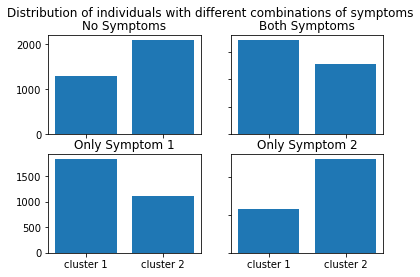

In [45]:
x_axis = ["cluster 1", "cluster 2"]
fig, axs = plt.subplots(2, 2)
axs[0, 0].bar(x_axis, no_sympt)
axs[0, 0].set_title("No Symptoms")
axs[0, 1].bar(x_axis, both_sympt)
axs[0, 1].set_title("Both Symptoms")
axs[1, 0].bar(x_axis, sympt_1)
axs[1, 0].set_title("Only Symptom 1")
axs[1, 1].bar(x_axis, sympt_2)
axs[1, 1].set_title("Only Symptom 2")
fig.suptitle("Distribution of individuals with different combinations of symptoms")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
#fig.savefig("/Users/mjdioli/Documents/STK-IN5000/ml-society-science/src/project-2/clustering.png")

In [46]:
placebo = 0
intervention = 0
action_and_stays_sick = 0
for a, y in zip(a_train["action"], y_train["outcome"]):
    if a== 1:
        if y==1:
            intervention+=1
        else:
            action_and_stays_sick+=1
    else:
        if y==1:
            placebo+=1

In [47]:
placebo

50

In [48]:
intervention

939

In [49]:
action_and_stays_sick

663

In [50]:
comb = x_train.copy()
comb["action"] = a_train["action"]
comb["outcome"] = y_train["outcome"]

In [51]:
combo = comb.loc[(comb["action"]==1)&(comb["outcome"]==0)]

gene 22      0.242836
gene 23      0.265460
gene 100     0.280543
gene 101     0.277526
gene 108     0.294118
symptom 2    0.274510
outcome      0.000000
dtype: float64


<BarContainer object of 3 artists>

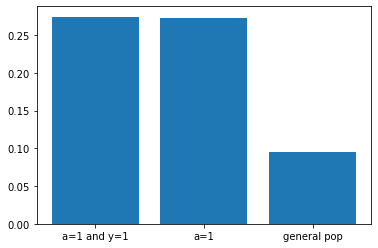

In [52]:
print(combo.sum(axis=0).apply(lambda x: x/len(combo))[lambda x: x<0.3])
presence_s2 = [combo.sum(axis=0).apply(lambda x: x/len(combo))[lambda x: x<0.3].loc["symptom 2"],
comb.loc[(comb["action"]==1)].sum(axis=0).apply(lambda x: x/len(comb.loc[(comb["action"]==1)])).loc["symptom 2"],
             comb.sum(axis=0).apply(lambda x: x/len(comb)).loc["symptom 2"]]
x_axis = ["a=1 and y=1", "a=1", "general pop"]
plt.bar(x_axis, presence_s2)

In [53]:
comb.loc[(comb["action"]==1)].sum(axis=0)

sex           827
smoker        481
gene 1        740
gene 2       1168
gene 3        869
             ... 
gene 126     1046
symptom 1    1428
symptom 2     437
action       1602
outcome       939
Length: 132, dtype: int64

gene 2       0.730015
gene 6       0.726998
gene 12      0.742081
gene 57      0.764706
gene 112     0.737557
gene 116     0.707391
gene 126     0.722474
symptom 1    0.874811
action       1.000000
dtype: float64


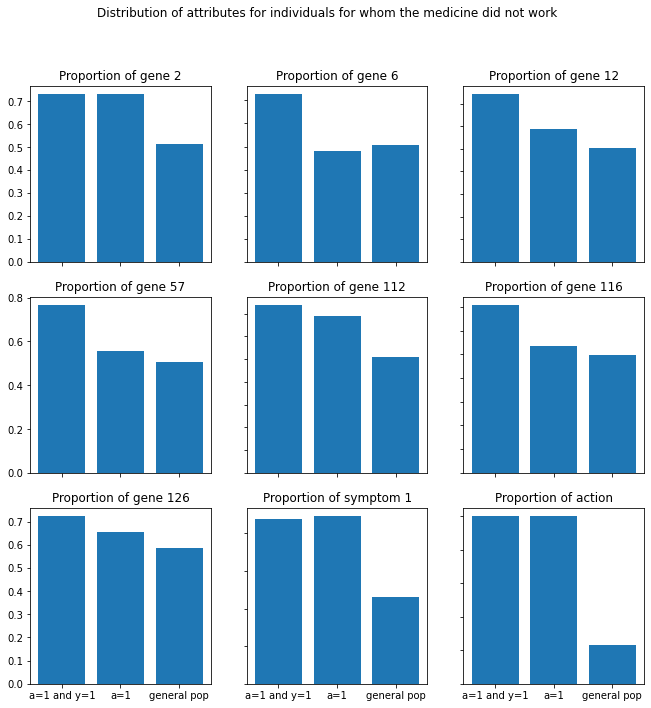

In [54]:
print(combo.sum(axis=0).apply(lambda x: x/len(combo))[lambda x: x>0.7])
fig, axs = plt.subplots(3, 3, figsize=(11,11))

# Hide x labels and tick labels for top plots and y ticks for right plots.

for i, ind in enumerate(list(combo.sum(axis=0).apply(lambda x: x/len(combo))[lambda x: x>0.7].index)):
    j=0
    presence_s2 = [combo.sum(axis=0).apply(lambda x: x/len(combo))[lambda x: x>0.7].loc[ind],
    comb.loc[(comb["action"]==1)].sum(axis=0).apply(lambda x: x/len(comb.loc[(comb["action"]==1)])).loc[ind],
                 comb.sum(axis=0).apply(lambda x: x/len(comb)).loc[ind]]
    x_axis = ["a=1 and y=1", "a=1", "general pop"]
    if 3<=i<=5:
        j=1
    elif 6<=i:
        j=2
    axs[j, i%3].bar(x_axis, presence_s2)
    axs[j, i%3].set_title("Proportion of "+ ind)
    #plt.title("Proportion of "+ ind +" in a population")
    #plt.savefig("/Users/mjdioli/Documents/STK-IN5000/ml-society-science/src/project-2/proportion_diff_07_" 
                #+ str(i) + ".png" )
    #plt.show()
for ax in axs.flat:
    ax.label_outer()
fig.suptitle("Distribution of attributes for individuals for whom the medicine did not work")
fig.savefig("img/proportion_diff_07.png")

gene 22      0.242836
gene 23      0.265460
gene 100     0.280543
gene 101     0.277526
gene 108     0.294118
symptom 2    0.274510
outcome      0.000000
dtype: float64


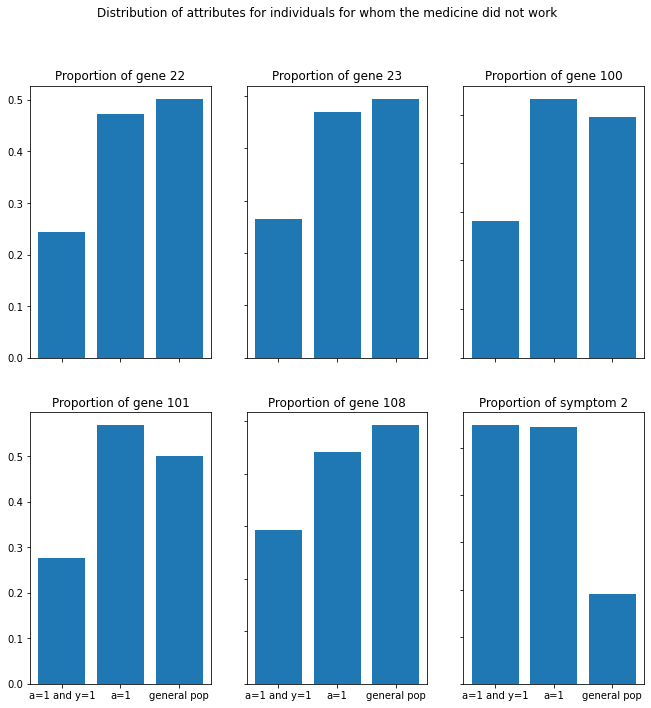

In [55]:
print(combo.sum(axis=0).apply(lambda x: x/len(combo))[lambda x: x<0.3])
fig, axs = plt.subplots(2, 3, figsize=(11,11))

# Hide x labels and tick labels for top plots and y ticks for right plots.

for i, ind in enumerate(list(combo.sum(axis=0).apply(lambda x: x/len(combo))[lambda x: x<0.3].index)):
    j=0
    presence_s2 = [combo.sum(axis=0).apply(lambda x: x/len(combo))[lambda x: x<0.3].loc[ind],
    comb.loc[(comb["action"]==1)].sum(axis=0).apply(lambda x: x/len(comb.loc[(comb["action"]==1)])).loc[ind],
                 comb.sum(axis=0).apply(lambda x: x/len(comb)).loc[ind]]
    x_axis = ["a=1 and y=1", "a=1", "general pop"]
    if 3<=i<=5:
        j=1
    elif 6<=i:
        j=2
    if i>=6:
        continue
    axs[j, i%3].bar(x_axis, presence_s2)
    axs[j, i%3].set_title("Proportion of "+ ind)
    #plt.title("Proportion of "+ ind +" in a population")
    #plt.savefig("/Users/mjdioli/Documents/STK-IN5000/ml-society-science/src/project-2/proportion_diff_07_" 
                #+ str(i) + ".png" )
    #plt.show()
for ax in axs.flat:
    ax.label_outer()
fig.suptitle("Distribution of attributes for individuals for whom the medicine did not work")
fig.savefig("img/proportion_diff_03.png")

In [56]:
print(combo.sum(axis=0).apply(lambda x: x/len(combo)))
#for ind in list(combo.sum(axis=0).apply(lambda x: x/len(combo)).index):
#    presence_s2 = [combo.sum(axis=0).apply(lambda x: x/len(combo)).loc[ind],
#    comb.loc[(comb["action"]==1)].sum(axis=0).apply(lambda x: x/len(comb.loc[(comb["action"]==1)])).loc[ind],
#                 comb.sum(axis=0).apply(lambda x: x/len(comb)).loc[ind]]
#    x_axis = ["a=1 and y=1", "a=1", "general pop"]
#    plt.bar(x_axis, presence_s2)
#    plt.title(ind)
#    plt.show()

sex          0.484163
smoker       0.307692
gene 1       0.645551
gene 2       0.730015
gene 3       0.562594
               ...   
gene 126     0.722474
symptom 1    0.874811
symptom 2    0.274510
action       1.000000
outcome      0.000000
Length: 132, dtype: float64


In [57]:
combo = comb.loc[(comb["action"]==1)&(comb["outcome"]==1)]

<BarContainer object of 132 artists>

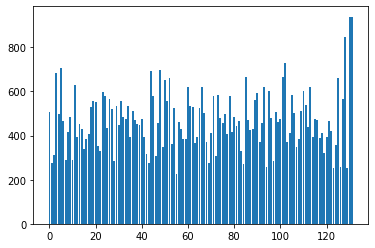

In [58]:
plt.bar(np.arange(132),combo.sum(axis=0))

In [59]:
combo.sum(axis=0).apply(lambda x: x/len(combo))[lambda x: x<0.3]

smoker       0.294995
gene 42      0.294995
gene 54      0.239617
gene 68      0.291800
gene 83      0.289670
gene 93      0.275825
gene 122     0.269436
gene 125     0.272630
symptom 2    0.271565
dtype: float64